# Import

In [1]:
# Загрузка ОС и файлов для работы на Kaggle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Загрузка библиотек

import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.stats import weightstats 
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
import warnings
warnings.simplefilter("ignore")

In [3]:
# Фиксация random seed для воспроизводимости экспериментов
RS = 42

In [4]:
# Загрузка данных в переменные
DATA_DIR = '/kaggle//input/sf-dst-scoring/'
train = pd.read_csv(DATA_DIR+'train.csv')
test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# Первичный взгляд на данные

In [5]:
sample_submission.sample(5)

,client_id,default
18655,101124,0.872456
16894,8784,0.780878
22052,22789,0.910745
18824,25493,0.184649
6570,87522,0.287766


In [6]:
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
12173,27132,03FEB2014,SCH,F,39,N,N,2,0,-1.634657,4,60,2,3,36000,3,2,N,1
72572,72102,20MAR2014,SCH,M,45,Y,Y,0,0,-2.889745,0,40,1,3,50000,1,3,N,0
9289,79537,27MAR2014,SCH,F,54,N,N,0,0,-2.477865,1,60,1,2,20000,1,3,N,0
21604,50119,27FEB2014,GRD,F,54,N,N,0,1,-2.126020,3,50,1,2,22000,4,1,N,0
29957,58593,07MAR2014,SCH,F,33,N,N,0,0,-2.028917,2,60,2,3,23000,4,1,N,0


## Описания полей

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Бросается в глаза, что даты в формате object

In [8]:
## Перевод в datetime
train.app_date = pd.to_datetime(train.app_date, infer_datetime_format=True)
print(train.app_date.dtype)
train.sample(5)

datetime64[ns]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
35167,54614,2014-03-03,GRD,F,32,N,N,0,0,-2.170154,5,50,2,3,30000,1,2,N,0
12263,72912,2014-03-20,UGR,F,42,Y,Y,0,0,-2.995554,1,80,2,3,70000,1,2,Y,0
44391,44783,2014-02-21,GRD,F,31,N,N,0,0,-2.387268,2,80,2,3,40000,2,3,Y,0
22784,69056,2014-03-17,SCH,F,41,N,N,0,0,-2.419830,1,50,1,1,45000,1,4,Y,0
20396,15146,2014-01-22,SCH,M,35,Y,Y,0,0,-0.474830,1,40,1,3,32000,4,2,N,0


## Пропуски

In [9]:
# Функция возвращяет визуализацию и относительную долю пропусков в данных
def na_values(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(df.isnull(),
                yticklabels=False, 
                cbar=False,
                cmap='viridis')
    plt.show()
    
    for column in df.columns:
        value = df[column].isna().sum()
        if value > 0:
            print(column.upper())
            print('%% пропущенных данных в столбце: \t{}'.format(np.round(value/len(df[column])*100), 2))
            print('(%% от общего кол-ва данных: \t{})'.format(np.round(value/np.product(df.shape)*100), 2))
            print()

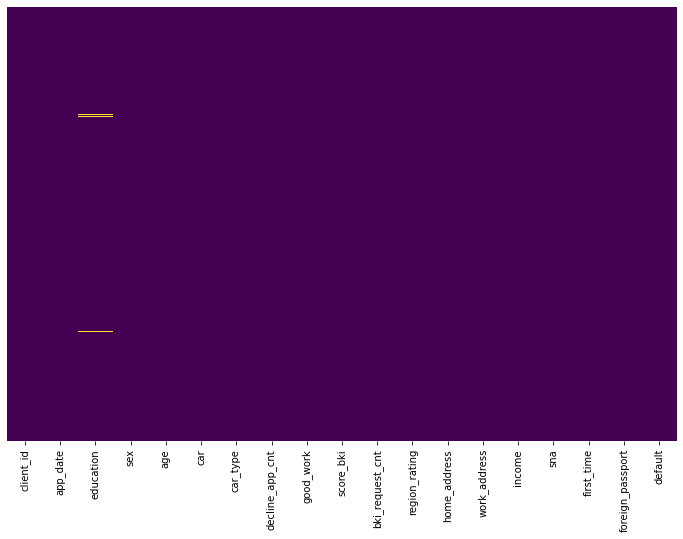

EDUCATION
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)



In [10]:
na_values(train)

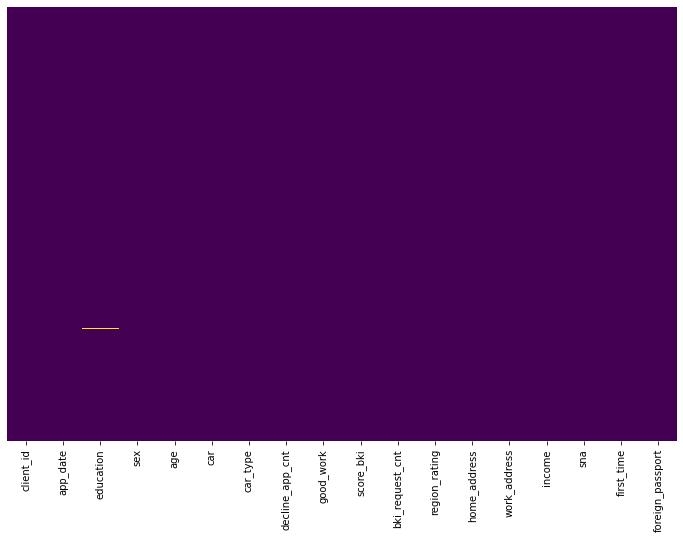

EDUCATION
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)



In [11]:
na_values(test)

### Вывод
Пропущена небольшая часть данных. Все пропуски по параметру education.

# EDA

In [12]:
# Проверка client_id
len(train.client_id.unique()) - train.shape[0]

0

ID клиента уникально для каждой стороки и не несет ценности в работе над тестовой выборкой.

In [13]:
train.drop('client_id', axis = 1, inplace = True)

## Предварительное рвзаделение данных по типу:

In [14]:
bin_cols = []
cat_cols = []
dat_cols = []
num_cols = []

for column in train.columns:
    if len(train[column].unique()) == 2:
        bin_cols.append(column)
    elif len(train[column].unique()) < 11:
        cat_cols.append(column)
    elif train[column].dtype == 'datetime64[ns]':
        dat_cols.append(column)
    else:
        num_cols.append(column)

print('Бинарные данные: \t', bin_cols)
print('Категориальные данные: \t', cat_cols)
print('Время/дата: \t\t', dat_cols)
print('Числовые данные: \t', num_cols)

Бинарные данные: 	 ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default']
Категориальные данные: 	 ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
Время/дата: 		 ['app_date']
Числовые данные: 	 ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


## Бинарные данные

In [15]:
#Функция, проверяющая наличае статистически значимых различий между вариациями признака
def get_stat_dif(df, col, target):
    variations=len(df[col].value_counts().index)
    indexes=[i for i in range (0,variations)]
    comb=list(combinations(indexes, 2))
    for c in comb:
        x = df[df[col] == df[col].value_counts().index[c[0]]][target]
        y = df[df[col] == df[col].value_counts().index[c[1]]][target]
        t_test = weightstats.ttest_ind(x, y, usevar='unequal')
        if t_test[1] <= 0.05/len(comb):
            return True
        else:
            return False

In [16]:
# Функция выводит основную информацию и график признака
def sum_up_cat(df, col, target):
    print(col.upper())
    vc = df[col].value_counts()
    vc_p = df[col].value_counts(normalize=True)
    for i in vc.index:
        print('{} (%%):\t{}'.format(i, np.round(vc_p[i],2)))
        print('\t Среднее значение целевой:\t{}'.format(np.round(df[df[col] == i][target].mean(),2)))
    print('Cтатистически значимые различия:\t{}'.format(get_stat_dif(df, col, target)))
    plt.figure()
    sns.catplot(data = df,  x = col, kind = 'count', palette = 'viridis')
    plt.show()

In [17]:
#Функция возвращает переменные с форматом 'object'
def obj_cols(df, cols):
    cols_to_encode = []
    for column in cols:
        if df[column].dtype == 'O':
            cols_to_encode.append(column)
    return cols_to_encode

SEX
F (%%):	0.56
	 Среднее значение целевой:	0.12
M (%%):	0.44
	 Среднее значение целевой:	0.13
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

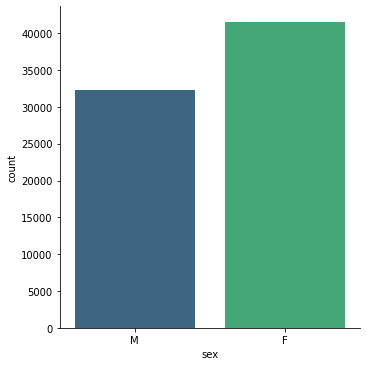

CAR
N (%%):	0.68
	 Среднее значение целевой:	0.14
Y (%%):	0.32
	 Среднее значение целевой:	0.11
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

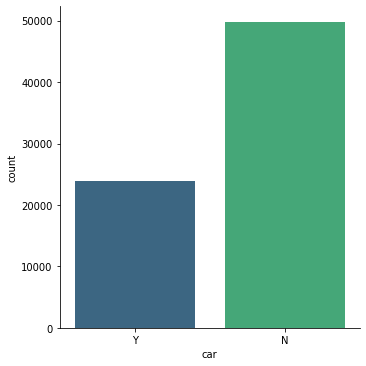

CAR_TYPE
N (%%):	0.81
	 Среднее значение целевой:	0.14
Y (%%):	0.19
	 Среднее значение целевой:	0.09
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

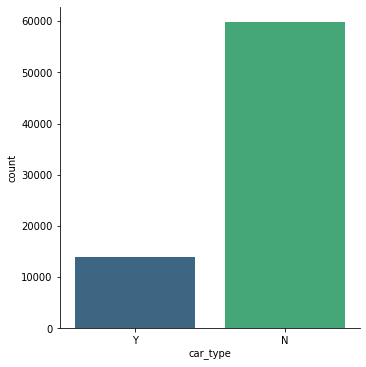

GOOD_WORK
0 (%%):	0.84
	 Среднее значение целевой:	0.13
1 (%%):	0.16
	 Среднее значение целевой:	0.09
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

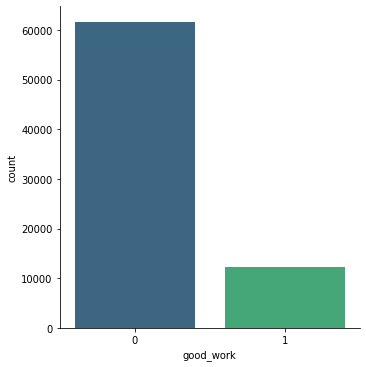

FOREIGN_PASSPORT
N (%%):	0.85
	 Среднее значение целевой:	0.14
Y (%%):	0.15
	 Среднее значение целевой:	0.07
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

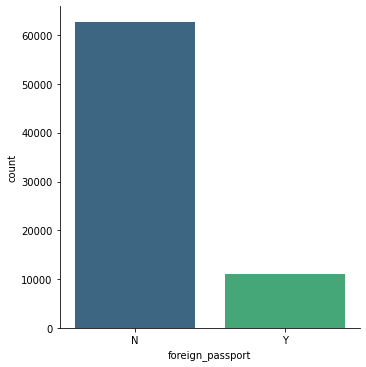

DEFAULT
0 (%%):	0.87
	 Среднее значение целевой:	0.0
1 (%%):	0.13
	 Среднее значение целевой:	1.0
Cтатистически значимые различия:	False


<Figure size 432x288 with 0 Axes>

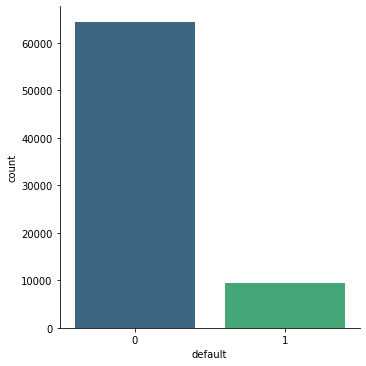

In [18]:
for column in bin_cols:
    sum_up_cat(train, column, 'default')

In [19]:
print('Необходимо перекодировать: \t', obj_cols(train, bin_cols))

Необходимо перекодировать: 	 ['sex', 'car', 'car_type', 'foreign_passport']


### Вывод

За исключением пола, признаки распределены не равномерно. Тем не менее, пропорция меньшинства в этих случаях более 10%% и нет необходимости изменять выборку.

Все признаки несут ценность для модели, доли дефолтных клиентов в них довольно заметно отличаются.

Ряд признаков необходимо перекотировать в числовой формат для дальнейшего использования.

In [20]:
label_encoder = LabelEncoder()

In [21]:
# Кодировка бинарных столбцов
for column in obj_cols(train, bin_cols):
    train[column] = label_encoder.fit_transform(train[column])
    print(column.upper())
    print(dict(enumerate(label_encoder.classes_)))
    print()

SEX
{0: 'F', 1: 'M'}

CAR
{0: 'N', 1: 'Y'}

CAR_TYPE
{0: 'N', 1: 'Y'}

FOREIGN_PASSPORT
{0: 'N', 1: 'Y'}



In [22]:
#Результат кодировки
train[bin_cols].sample(5)

,sex,car,car_type,good_work,foreign_passport,default
29632,0,0,0,1,0,1
54253,0,1,1,0,0,0
53441,1,0,0,0,0,0
21638,0,1,0,0,0,0
14460,1,1,1,0,0,0


## Категориальные данные

EDUCATION
SCH (%%):	0.53
	 Среднее значение целевой:	0.15
GRD (%%):	0.32
	 Среднее значение целевой:	0.09
UGR (%%):	0.13
	 Среднее значение целевой:	0.13
PGR (%%):	0.02
	 Среднее значение целевой:	0.06
ACD (%%):	0.0
	 Среднее значение целевой:	0.04
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

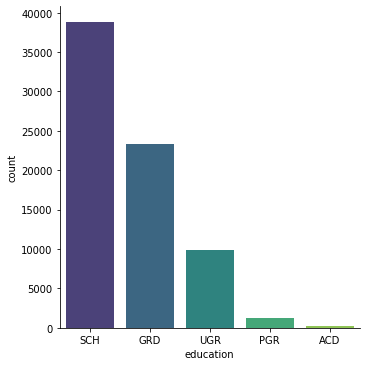

REGION_RATING
50 (%%):	0.37
	 Среднее значение целевой:	0.14
60 (%%):	0.22
	 Среднее значение целевой:	0.13
40 (%%):	0.16
	 Среднее значение целевой:	0.17
80 (%%):	0.16
	 Среднее значение целевой:	0.07
70 (%%):	0.08
	 Среднее значение целевой:	0.09
30 (%%):	0.0
	 Среднее значение целевой:	0.19
20 (%%):	0.0
	 Среднее значение целевой:	0.21
Cтатистически значимые различия:	False


<Figure size 432x288 with 0 Axes>

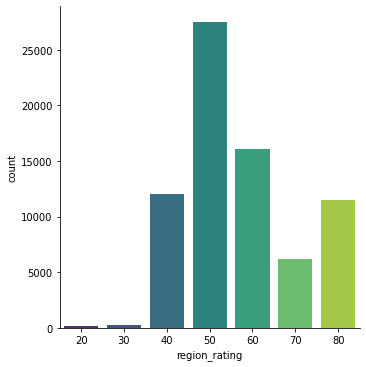

HOME_ADDRESS
2 (%%):	0.54
	 Среднее значение целевой:	0.16
1 (%%):	0.44
	 Среднее значение целевой:	0.09
3 (%%):	0.02
	 Среднее значение целевой:	0.12
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

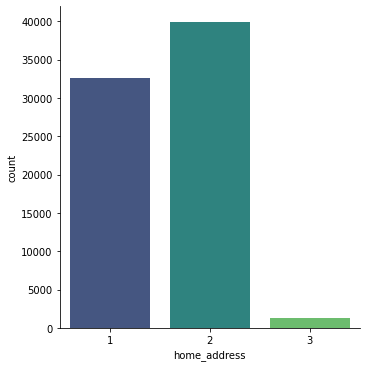

WORK_ADDRESS
3 (%%):	0.61
	 Среднее значение целевой:	0.15
2 (%%):	0.28
	 Среднее значение целевой:	0.1
1 (%%):	0.11
	 Среднее значение целевой:	0.07
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

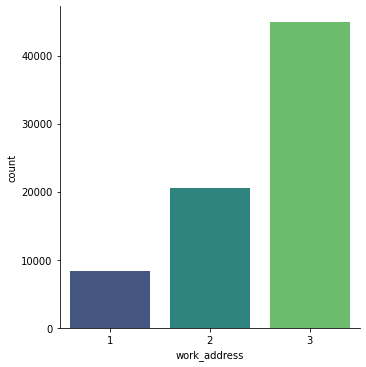

SNA
1 (%%):	0.64
	 Среднее значение целевой:	0.1
4 (%%):	0.16
	 Среднее значение целевой:	0.21
2 (%%):	0.14
	 Среднее значение целевой:	0.15
3 (%%):	0.06
	 Среднее значение целевой:	0.16
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

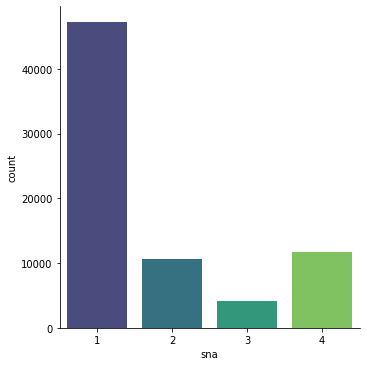

FIRST_TIME
3 (%%):	0.42
	 Среднее значение целевой:	0.12
4 (%%):	0.25
	 Среднее значение целевой:	0.08
1 (%%):	0.17
	 Среднее значение целевой:	0.19
2 (%%):	0.16
	 Среднее значение целевой:	0.16
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

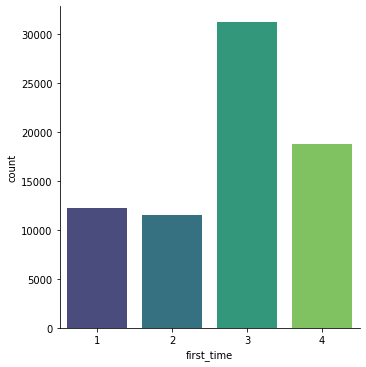

In [23]:
for column in cat_cols:
    sum_up_cat(train, column, 'default')

In [24]:
print('Необходимо перекодировать: \t', obj_cols(train, cat_cols))

Необходимо перекодировать: 	 ['education']


In [25]:
# Сравнение пропущенный и заполненных
print('EDUCATION')
print('Среднее значение целевой (заполненные): \t', np.round(train[train.education.isna() == False].default.mean(),2))
print('Среднее значение целевой (пропущенyые): \t', np.round(train[train.education.isna() == True].default.mean(),2))

EDUCATION
Среднее значение целевой (заполненные): 	 0.13
Среднее значение целевой (пропущенyые): 	 0.11


### Вывод

EDUCATION:

    Судя по значениям default rate для распределения, доля людей с категорией образования не отображает его уровень. Предпологаемая рассшифровка признака:

        SCH = school
        UGR = undergraduate
        GRD = graduate
        PGR = postgraduate
        ACD = advanced college degree
    
    Таким образом прризнак имеет смысл перекодировать в ручную. Что касается пропущенных значений, для них default rate ниже среднего по выборке. Что подтверждает то, что имеет смысл предсказать пропущенные значения, и мало вероятно, что они говорят об отсутствии образования. В дальнейшем для предсказания признака, необходимо сместить выборку для увеличения доли 'PGR' и'ACD'.

REGION_RATING:

    Признак имеет явную линейную зависимость с default rate. Так же, заметно, что ег распеределение условно нормально. Иммет смысл перенести его в числовые переменные.
    
Остальные признаки несут ценность для модели. Имееются низкие доли знвчений для признаков HOME_ADDRESS и SNA. Но, в этих случаях наблюдается отклонение default rate, и недооценка моделью этих значений может быть оправдана. 

In [26]:
# Перенос region_rating
cat_cols.remove('region_rating')
num_cols.append('region_rating')

In [27]:
# Кодировка education
mapping_dict = {'SCH': 1, 'UGR': 2, 'GRD':3, 'PGR':4, 'ACD':5}
train['education'] = train.education.map(mapping_dict)

In [28]:
#Результат кодировки
train[cat_cols].sample(5)

,education,home_address,work_address,sna,first_time
7664,3.0,2,3,1,4
3655,1.0,1,2,1,3
6374,3.0,2,3,1,3
4510,3.0,2,3,1,4
35230,1.0,1,2,1,2


## Числовые данные

In [29]:
# Функция расчитывает кол-во выбросов по столбцам и их долю
def outbursts(df, col):
    Q25 = df[col].quantile(0.25)
    Q75 = df[col].quantile(0.75)
    IQR = Q75 - Q25
    lowest = Q25 - 1.5*IQR
    highest = Q75 + 1.5*IQR
    amount = df[(df[col] < lowest)|(df[col] > highest)].count()[0]
    ratio = amount/df.shape[0]
    return amount, ratio, lowest, highest

In [30]:
#Функция выводит основную информацию и график признака
def sum_up_num(df, col, target):
    print(col.upper())
    print(df[col].describe()[1:])
    print('Кол-во выбросов: {} \t (%%: {})'.format(outbursts(df, col)[0], 
                                                   np.round(outbursts(df, col)[1]*100,2)))
    print()
    fig, axs = plt.subplots(figsize=(15, 5), ncols=2)
    sns.distplot(df[col], kde=True, ax=axs[0])
    sns.boxplot(data = df,  x = col, palette = 'viridis', ax=axs[1])
    plt.show()

AGE
mean    39.280641
std     11.520378
min     21.000000
25%     30.000000
50%     37.000000
75%     48.000000
max     72.000000
Name: age, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



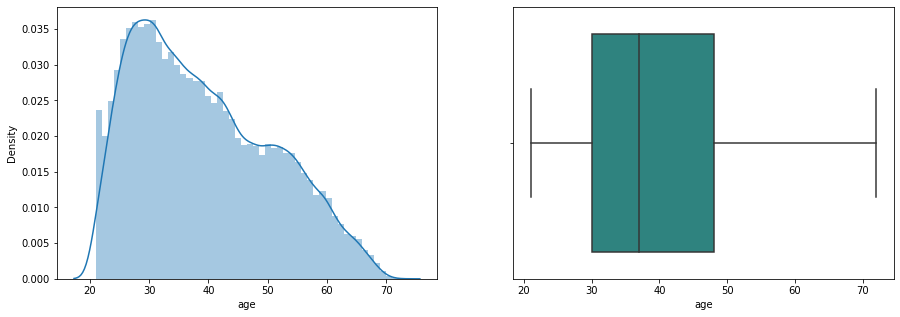

DECLINE_APP_CNT
mean     0.275749
std      0.804272
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     33.000000
Name: decline_app_cnt, dtype: float64
Кол-во выбросов: 12585 	 (%%: 17.05)



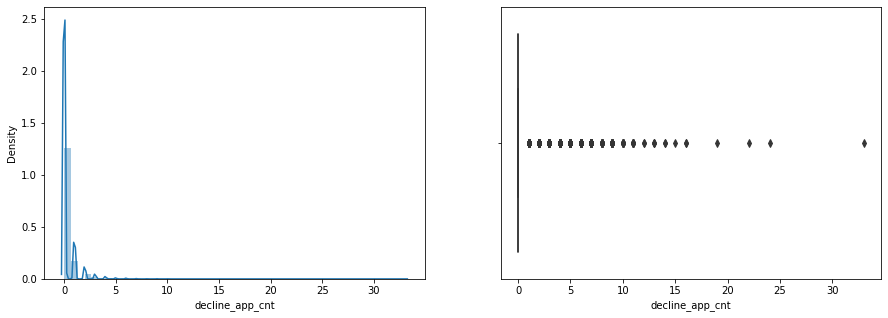

SCORE_BKI
mean   -1.904724
std     0.498231
min    -3.624586
25%    -2.259534
50%    -1.920823
75%    -1.569831
max     0.199773
Name: score_bki, dtype: float64
Кол-во выбросов: 351 	 (%%: 0.48)



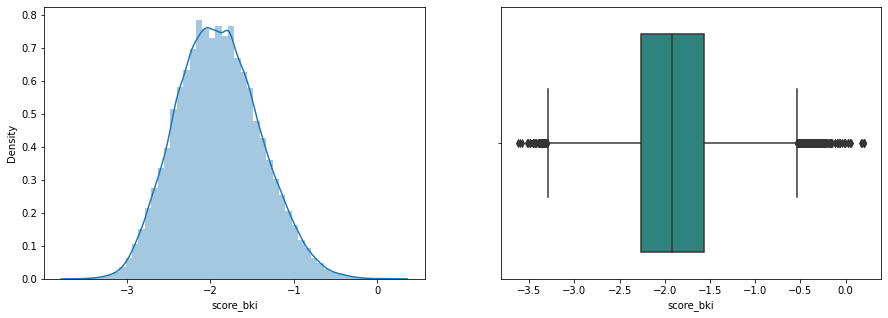

BKI_REQUEST_CNT
mean     2.000339
std      2.252073
min      0.000000
25%      0.000000
50%      1.000000
75%      3.000000
max     53.000000
Name: bki_request_cnt, dtype: float64
Кол-во выбросов: 1755 	 (%%: 2.38)



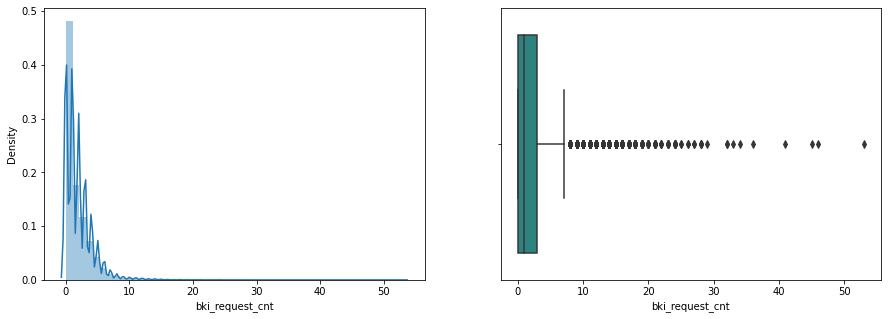

INCOME
mean      41099.775417
std       46166.322400
min        1000.000000
25%       20000.000000
50%       30000.000000
75%       48000.000000
max     1000000.000000
Name: income, dtype: float64
Кол-во выбросов: 4695 	 (%%: 6.36)



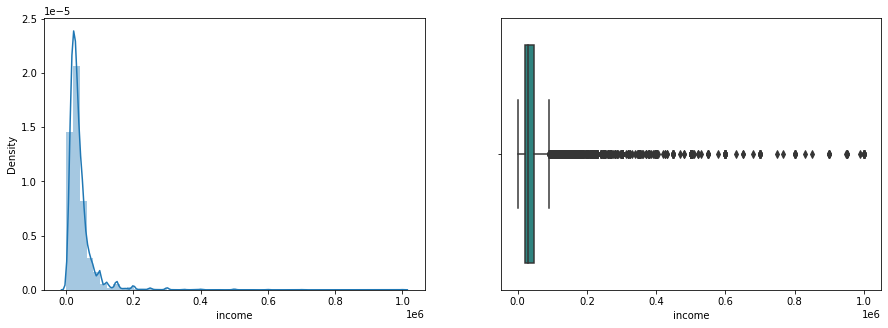

REGION_RATING
mean    56.725701
std     13.055717
min     20.000000
25%     50.000000
50%     50.000000
75%     60.000000
max     80.000000
Name: region_rating, dtype: float64
Кол-во выбросов: 11975 	 (%%: 16.23)



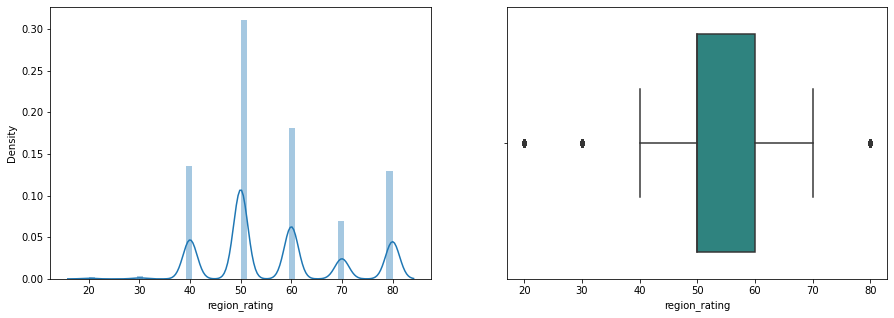

In [31]:
for column in num_cols:
    sum_up_num(train, column, 'default')

Из 6 числовых переменных: 2 - нормальныо распределены, 4 - логнормально. Следовательно, необходимо преобразовать столбцы: age, decline_app_cnt, bki_request_cnt, income. Вместе с тем, для первых двух минимальное значение равно 0. Так же, можно уменьшить размерность region_rating.

Имеются выбросы в данных.

In [32]:
# Предобработка столбцов, имеющих значение 0
for col in ['decline_app_cnt', 'bki_request_cnt']:
    train[col] = train[col].apply(lambda x: x+1)

In [33]:
# Нормализация
for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    train[col] = stats.boxcox(train[col])[0]

In [34]:
# Изменение размерности
train['region_rating'] = train['region_rating']/100

AGE
mean    3.240389
std     0.232844
min     2.769830
25%     3.060851
50%     3.228933
75%     3.434468
max     3.747995
Name: age, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



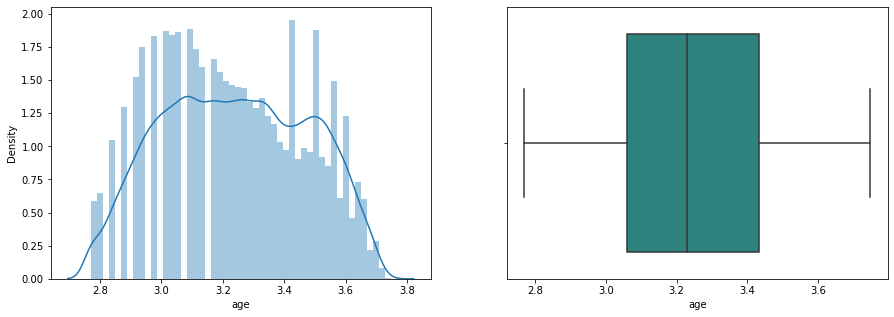

DECLINE_APP_CNT
mean    0.026804
std     0.059116
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     0.158546
Name: decline_app_cnt, dtype: float64
Кол-во выбросов: 12585 	 (%%: 17.05)



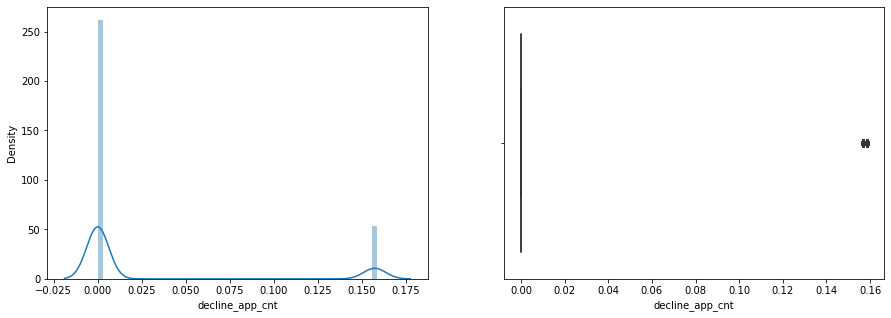

SCORE_BKI
mean   -1.904724
std     0.498231
min    -3.624586
25%    -2.259534
50%    -1.920823
75%    -1.569831
max     0.199773
Name: score_bki, dtype: float64
Кол-во выбросов: 351 	 (%%: 0.48)



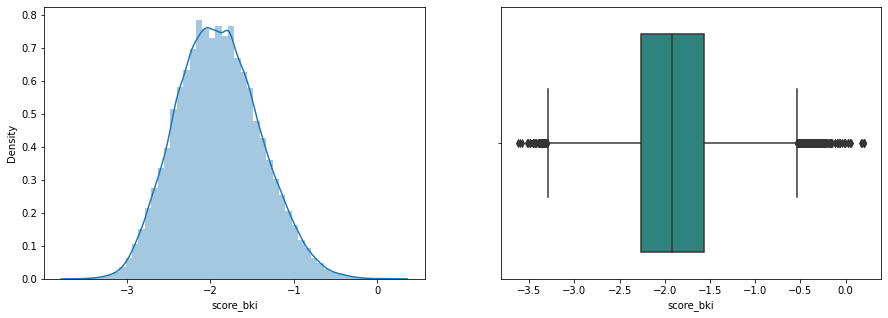

BKI_REQUEST_CNT
mean    0.807436
std     0.587435
min     0.000000
25%     0.000000
50%     0.663986
75%     1.272896
max     3.141523
Name: bki_request_cnt, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



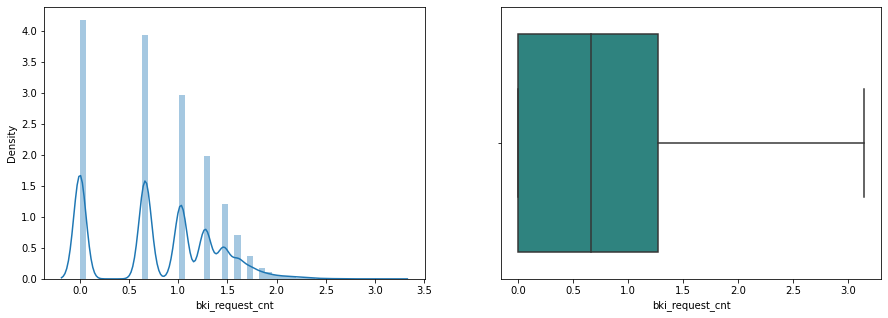

INCOME
mean    5.670380
std     0.179519
min     4.553056
25%     5.560409
50%     5.668952
75%     5.787797
max     6.402578
Name: income, dtype: float64
Кол-во выбросов: 1619 	 (%%: 2.19)



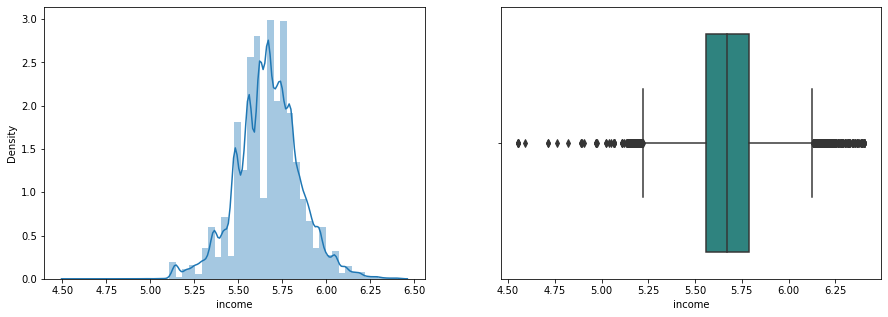

REGION_RATING
mean    0.567257
std     0.130557
min     0.200000
25%     0.500000
50%     0.500000
75%     0.600000
max     0.800000
Name: region_rating, dtype: float64
Кол-во выбросов: 11975 	 (%%: 16.23)



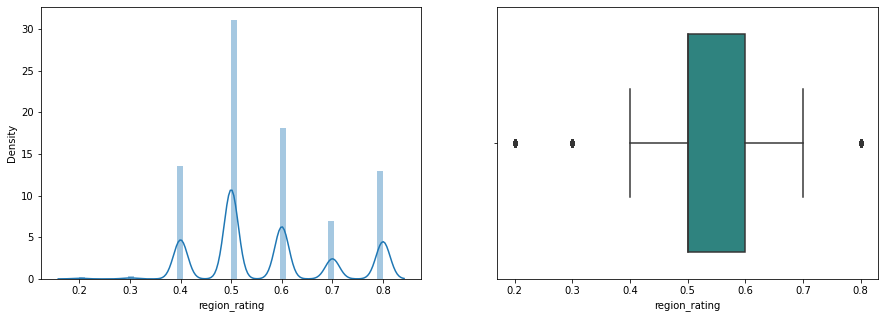

In [35]:
for column in num_cols:
    sum_up_num(train, column, 'default')

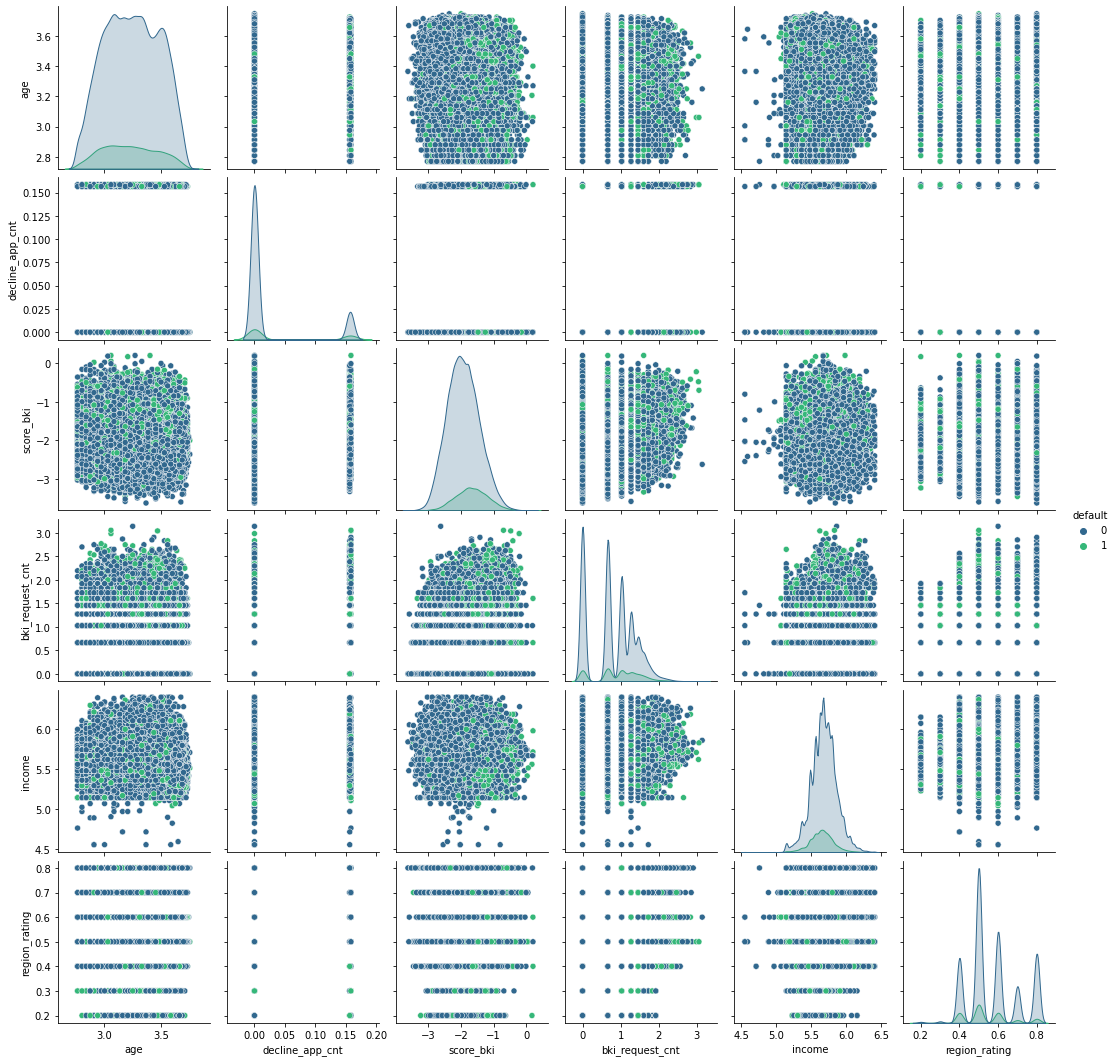

In [36]:
sns.pairplot(train[num_cols+['default']], hue = 'default', palette = 'viridis')

Обработка данных позволила привести к нормальному распределению параметры 'age' и 'income'. Так же, удалось снизить кол-во выбросов данных. 'decline_app_cnt' после нормализации имеет два ярко выраженных пика, что позволяет перекодировать признак в бинарный.

DECLINE_APP_CNT
0 (%%):	0.83
	 Среднее значение целевой:	0.11
1 (%%):	0.17
	 Среднее значение целевой:	0.21
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

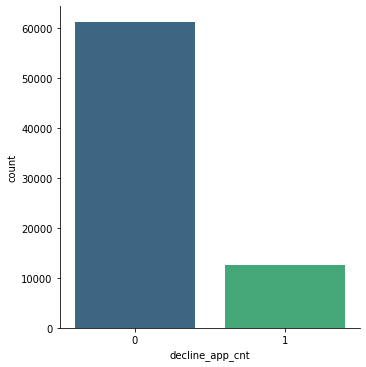

In [37]:
# Перекодировка decline_app_cnt
train['decline_app_cnt'] = train.decline_app_cnt.apply(lambda x: 1 if x>0 else 0)
sum_up_cat(train, 'decline_app_cnt', 'default')

In [38]:
# Перенос decline_app_cnt
num_cols.remove('decline_app_cnt')
bin_cols.append('decline_app_cnt')

<AxesSubplot:>

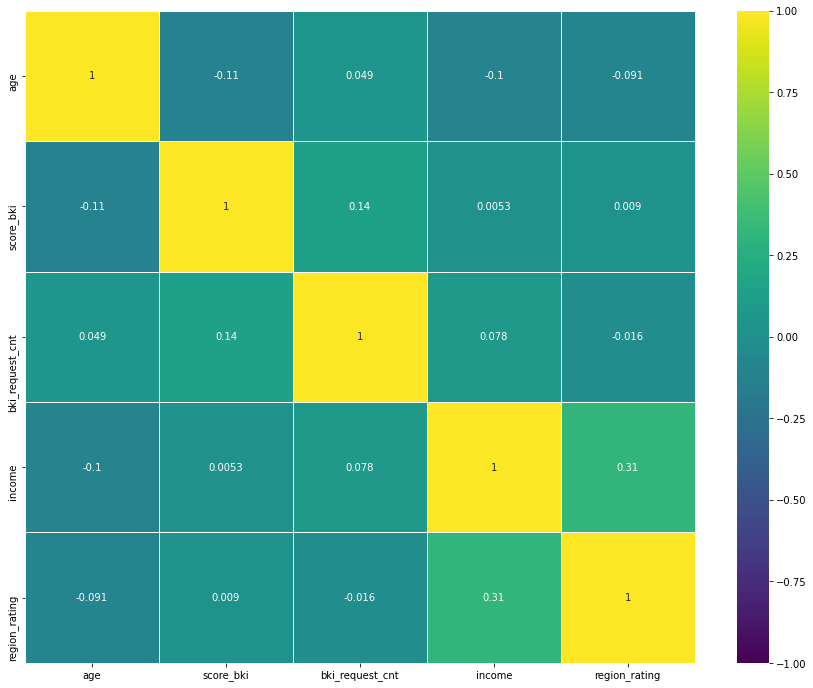

In [39]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

### Вывод

За исключением 'bki_request_cnt', числовые данные приведены к нормальному распределнию. В данных сохраняются выбросы.

Построенние коррелиционной матрицы не выявило высоких значений, которые могли бы препядствовать работе модели.

## Время/дата

In [40]:
train['app_year'] = train.app_date.dt.year
train['app_month'] = train.app_date.dt.month
train['app_week_day'] = train.app_date.dt.dayofweek
train['timestamp'] = train.app_date.values.astype(np.int64) // 10 ** 9

APP_YEAR
2014 (%%):	1.0
	 Среднее значение целевой:	0.13
Cтатистически значимые различия:	None


<Figure size 432x288 with 0 Axes>

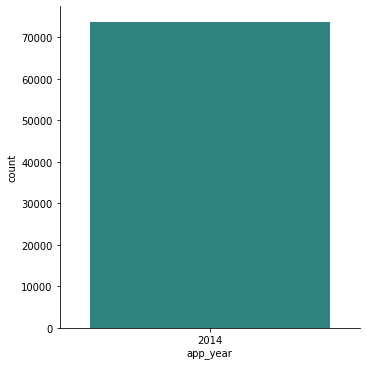

APP_MONTH
3 (%%):	0.29
	 Среднее значение целевой:	0.13
2 (%%):	0.24
	 Среднее значение целевой:	0.13
4 (%%):	0.24
	 Среднее значение целевой:	0.11
1 (%%):	0.23
	 Среднее значение целевой:	0.14
Cтатистически значимые различия:	False


<Figure size 432x288 with 0 Axes>

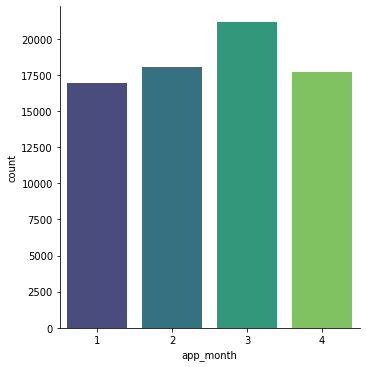

APP_WEEK_DAY
1 (%%):	0.16
	 Среднее значение целевой:	0.13
0 (%%):	0.16
	 Среднее значение целевой:	0.13
2 (%%):	0.16
	 Среднее значение целевой:	0.12
3 (%%):	0.16
	 Среднее значение целевой:	0.13
4 (%%):	0.15
	 Среднее значение целевой:	0.12
5 (%%):	0.11
	 Среднее значение целевой:	0.13
6 (%%):	0.09
	 Среднее значение целевой:	0.13
Cтатистически значимые различия:	False


<Figure size 432x288 with 0 Axes>

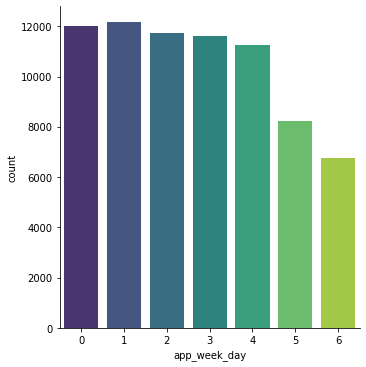

In [41]:
for category in ['app_year', 'app_month', 'app_week_day']:
    sum_up_cat(train, category, 'default')

TIMESTAMP
mean    1.393808e+09
std     2.775331e+06
min     1.388534e+09
25%     1.391386e+09
50%     1.393891e+09
75%     1.396224e+09
max     1.398816e+09
Name: timestamp, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



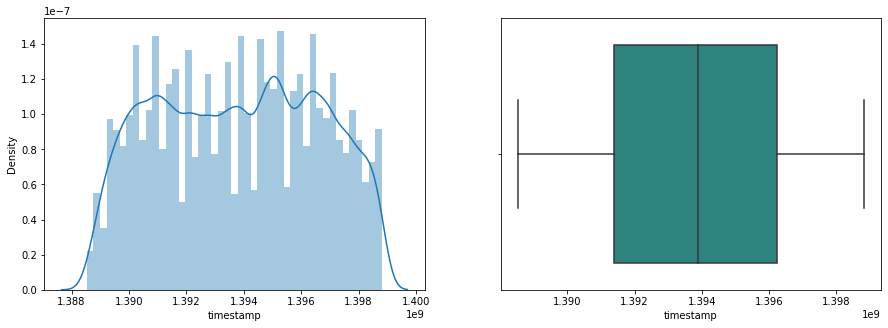

In [42]:
sum_up_num(train, 'timestamp', 'default')

### Вывод

Данные предоставлены за 4 месяца 2014 года. Найдены статистически значимые различия между месяцами. Default rate для месяцев снижается. Не ясно, является ли эта закономерность отображение объективного тренда. В любом случае, иммет смысл сохранить данные. Насколько данные переменные полезны для модели будет проанализировано позже.

Столбец 'app_month' иммет 4 уникальных значения и может рассмотриваться как категориальный признак.

Столбцы 'app_year' и 'app_week_day' будут удалены, т.к. не несут ценности.

In [43]:
num_cols.append('timestamp')
cat_cols.append('app_month')

In [44]:
train.drop(['app_date', 'app_year', 'app_week_day'], axis = 1, inplace = True)

## Итоговый DataFrame

In [45]:
train.sample(5)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_month,timestamp
9962,1.0,1,3.620765,1,0,1,0,-1.490639,0.663986,0.4,2,3,5.292909,1,3,0,0,2,1392768000
24246,1.0,1,3.466398,0,0,0,0,-2.676010,0.663986,0.5,1,3,5.479840,1,4,0,0,2,1393286400
52270,2.0,1,2.844680,0,0,0,0,-1.174574,1.026559,0.5,2,3,5.560409,1,3,0,0,2,1393027200
69873,1.0,0,3.540629,0,0,0,0,-1.362578,1.457966,0.5,1,2,5.515265,4,4,0,0,2,1392508800
15122,3.0,0,3.383819,0,0,0,1,-2.009020,1.605396,0.6,1,1,5.560409,2,4,0,0,3,1394496000


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73492 non-null  float64
 1   sex               73799 non-null  int64  
 2   age               73799 non-null  float64
 3   car               73799 non-null  int64  
 4   car_type          73799 non-null  int64  
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  float64
 9   region_rating     73799 non-null  float64
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  float64
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  int64  
 16  default           73799 non-null  int64 

Удаляем 'default' из категориальных признаков, т. к. он не участвует в обработке данных

In [47]:
bin_cols.remove('default')

# Наивная модель

In [48]:
# Создание предобработок данных
main_OHE = OneHotEncoder(sparse = False)
main_SS = StandardScaler()

In [49]:
# Функция возвращает метрики для данных и модели
def metics(data, target, model=LogisticRegression(random_state = RS)):
    # Предобработка
    X_cat = main_OHE.fit_transform(data[cat_cols].values)
    X_num = main_SS.fit_transform(data[num_cols].values)
    X = np.hstack([X_num, data[bin_cols].values, X_cat])
    y = train[target].values
    
    # Разбиение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = RS)
    
    # Моделирование
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    #Метрики
    result = []
    result.append(roc_auc_score(y_test,y_prob[:,1]))
    result.append(accuracy_score(y_test, y_pred))
    result.append(precision_score(y_test, y_pred))
    result.append(recall_score(y_test, y_pred))
    result.append(f1_score(y_test, y_pred))
    
    return result

In [50]:
results = pd.DataFrame({'naive': metics(train, 'default')}, 
                       index = ['ROC AUC','Accuracy','Precision','Recall','F1 score'])
results

,naive
ROC AUC,0.744060
Accuracy,0.874932
Precision,0.405941
Recall,0.022441
F1 score,0.042531


## Памятка по метрикам:
- ROC AUC Площадь под кривой. Метрика отбражает вероятность предсказать правильное значение (y), относительно ошибки (x). Теоретический максимум = 1, значение рандома = 0.5.
- Accuracy: (TN+TP)/(TP+TN+FP+FN) - отношение верно предсказанных к общему кол-ву объектов
- Precision: TP/(TP+FP) - сколько из значений, предсказаных позитивными, являются таковыми
- Recall: TP/(TP+FN) - доля из всех положительных, предсказанная верно
- F1 score: 2*Precision*Recall/(Precision+Recall) - среднее гармоническое между двумя вышеописанными метриками

# Заполнение пропусков 'education'

## 1. Заполнение нулями

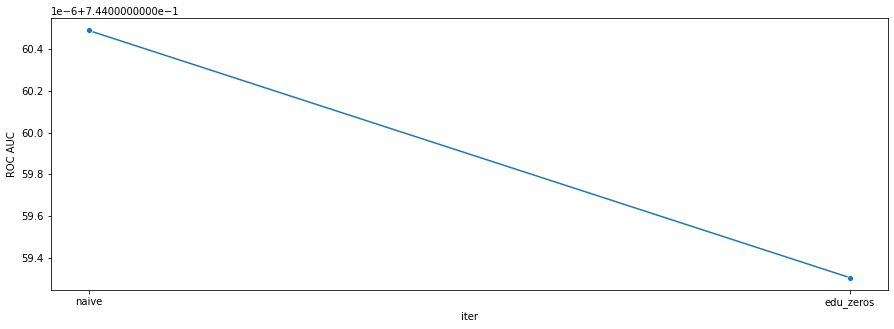

,naive,edu_zeros
ROC AUC,0.744060,0.744059
Accuracy,0.874932,0.874932
Precision,0.405941,0.405941
Recall,0.022441,0.022441
F1 score,0.042531,0.042531


In [51]:
zeros = train.fillna(0)
results['edu_zeros'] = metics(zeros, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

## 2. Заполнение медианой

In [52]:
# Медиана
train['education'].median()

1.0

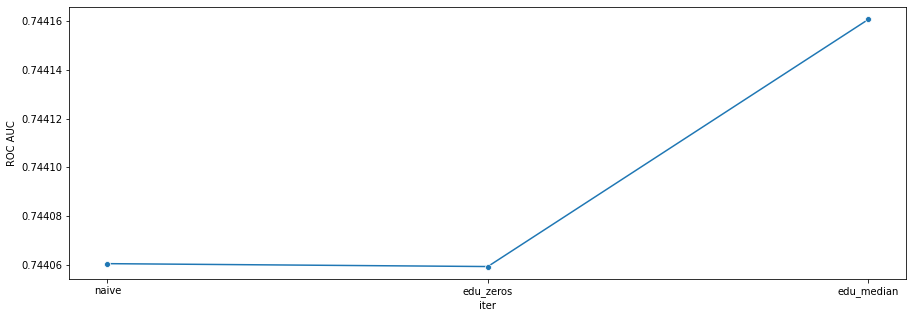

,naive,edu_zeros,edu_median
ROC AUC,0.744060,0.744059,0.744161
Accuracy,0.874932,0.874932,0.875000
Precision,0.405941,0.405941,0.411765
Recall,0.022441,0.022441,0.022989
F1 score,0.042531,0.042531,0.043546


In [53]:
median = train.copy()
median['education'].fillna(median['education'].median(), inplace=True)
results['edu_median'] = metics(median, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

## 3. Заполнение средним

In [54]:
# Медиана
np.round(train['education'].mean())

2.0

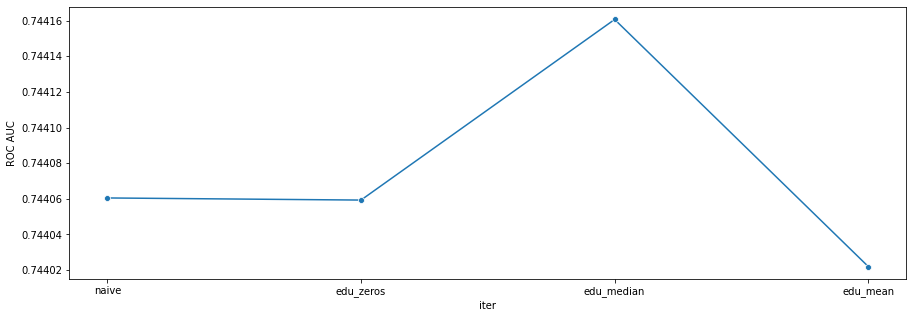

,naive,edu_zeros,edu_median,edu_mean
ROC AUC,0.744060,0.744059,0.744161,0.744022
Accuracy,0.874932,0.874932,0.875000,0.875000
Precision,0.405941,0.405941,0.411765,0.410000
Recall,0.022441,0.022441,0.022989,0.022441
F1 score,0.042531,0.042531,0.043546,0.042553


In [55]:
mean = train.copy()
mean['education'].fillna(np.round(mean['education'].mean()), inplace=True)
results['edu_mean'] = metics(mean, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

## 4. Моделирование

EDUCATION
1.0 (%%):	0.53
	 Среднее значение целевой:	0.15
3.0 (%%):	0.32
	 Среднее значение целевой:	0.09
2.0 (%%):	0.13
	 Среднее значение целевой:	0.13
4.0 (%%):	0.02
	 Среднее значение целевой:	0.06
5.0 (%%):	0.0
	 Среднее значение целевой:	0.04
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

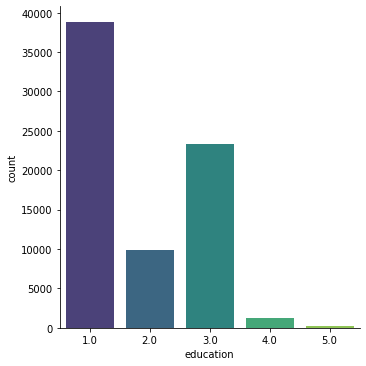

In [56]:
sum_up_cat(train, 'education', 'default')

### Undersampling
Так как, в данных доля 4го и 5го классов (PGR и ACD) крайне мала, необходимо устранить диссбаланс выборки.

Метод undersampling выбран в целях быстродействия (переменная не является целевой и пропусков в ней не очень много).

In [57]:
# Функция возвращает сбаласированную выборку, сохраняя пропорции среди преобладающих значений
def undersampling(df, col, min_frac = 0.1):
    vc = df[col].dropna().value_counts(ascending=True)
    min_value = vc.min()
    to_distribute = min_value/min_frac*(1-len(vc)*min_frac)
    parts = []
    count = 0
    for i in vc.index:
        if vc[i]/vc[i:].sum() < min_frac:
            parts.append(df[df[col] == i].copy().sample(n=min_value, random_state=RS))
            count += 1
        else:
            add_value = vc[i]/vc.iloc[count:].sum()*to_distribute
            parts.append(df[df[col] == i].copy().sample(n=(min_value+int(add_value)), random_state=RS))
    sample = pd.concat(parts)
    return sample

EDUCATION
1.0 (%%):	0.37
	 Среднее значение целевой:	0.15
3.0 (%%):	0.26
	 Среднее значение целевой:	0.11
2.0 (%%):	0.17
	 Среднее значение целевой:	0.14
5.0 (%%):	0.1
	 Среднее значение целевой:	0.04
4.0 (%%):	0.1
	 Среднее значение целевой:	0.08
Cтатистически значимые различия:	False


<Figure size 432x288 with 0 Axes>

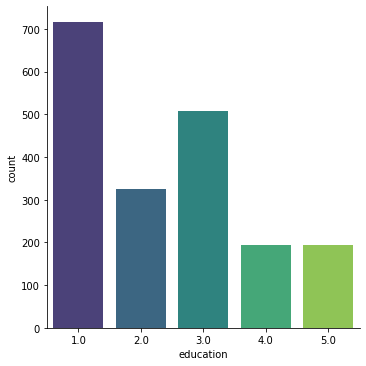

In [58]:
# Применение функции, отображение итога
edu_sample = undersampling(train, 'education')
sum_up_cat(edu_sample, 'education', 'default')

### Feature selection

In [59]:
# Функция измеряет взаимную информацию для ряда переменных
def mi_class(features, target):
    mi_scores = mutual_info_classif(features, target, random_state = RS)
    mi_scores = pd.Series(mi_scores, index=features.columns)
    return mi_scores

In [60]:
# Фунция возвращает параметры из списка, для который MI score выше определенного значения
def mi_test(cols, value = 0.01):
    useful_cols = []
    for col in cols:
        if mi_scores[col]>value:
            useful_cols.append(col)
    return useful_cols

<AxesSubplot:>

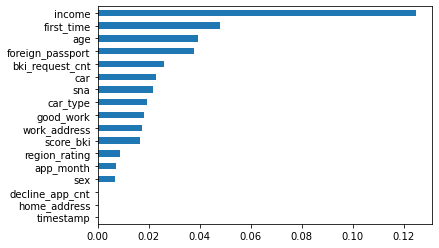

In [61]:
# Расчет взаимной иформации
features = edu_sample.copy().drop(['education','default'], axis = 1)
target = edu_sample.education
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

In [62]:
# Создание списков переменных, которые ценны для предсказания education
edu_bin_cols = mi_test(bin_cols, 0.01)
print(edu_bin_cols)
edu_num_cols = mi_test(num_cols, 0.01)
print(edu_num_cols)
edu_cat_cols = mi_test(cat_cols[1:], 0.01)
print(edu_cat_cols)

['car', 'car_type', 'good_work', 'foreign_passport']
['age', 'score_bki', 'bki_request_cnt', 'income']
['work_address', 'sna', 'first_time']


### Классификаторы

In [63]:
# Создание предобработки признаков (dummy-переменные, стандартизация)
edu_OHE = OneHotEncoder(sparse = False)
edu_OHE.fit(edu_sample[edu_cat_cols].values)
edu_SS = StandardScaler()
edu_SS.fit(edu_sample[edu_num_cols].values)

StandardScaler()

In [64]:
# Применеие предобработки
W_cat = edu_OHE.transform(edu_sample[edu_cat_cols].values)
W_num = edu_SS.transform(edu_sample[edu_num_cols].values)
W = np.hstack([W_num, edu_sample[edu_bin_cols].values, W_cat])
z = edu_sample.education.values

In [65]:
# Разбиение выборки
W_train, W_add, z_train, z_add = train_test_split(W, z, test_size=0.2, random_state=RS)
W_test, W_valid, z_test, z_valid = train_test_split(W_add, z_add, test_size=0.5, random_state=RS)

In [66]:
# Значения гиперпараметров для тестирования LogisticRegression
C = [0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
warm_start = [True, False]

# Значения гиперпараметров для тестирования KNeighborsClassifier
n_neighbors = [3, 5, 7, 10]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Значения гиперпараметров для тестирования DecisionTreeClassifier
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3, 5, 7, 10]

# Словарь для более удобной работы с моделями в цикле
edu_models = {'LR': {'model': LogisticRegression(random_state=RS, max_iter=25), 
                     'params': {'C': C, 'penalty': penalty, 'solver': solver, 
                                'warm_start': warm_start}},
              'KN' : {'model' : KNeighborsClassifier(), 
                      'params': {'n_neighbors': n_neighbors,  'weights': weights, 
                                 'algorithm': algorithm}}, 
              'DT' : {'model': DecisionTreeClassifier(random_state=RS), 
                      'params': {'criterion': criterion,  'splitter': splitter, 
                                 'max_depth': max_depth}}
             }

Benchmark F1 (random): 		 0.2721350801647576
Benchmark F1 (most common): 	 0.17272006344171292

LogisticRegression(max_iter=25, random_state=42)
Лучшие параметры: 		 {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
F1 score: 			 0.34520084752594044
Confusion matrix:


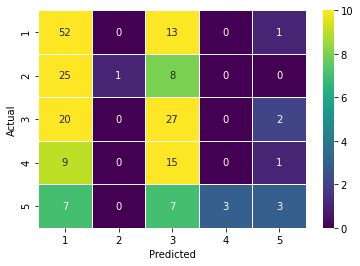

KNeighborsClassifier()
Лучшие параметры: 		 {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
F1 score: 			 0.37891485559069643
Confusion matrix:


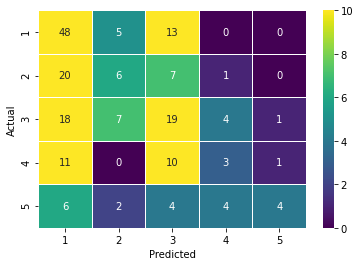

DecisionTreeClassifier(random_state=42)
Лучшие параметры: 		 {'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'}
F1 score: 			 0.4176768989342905
Confusion matrix:


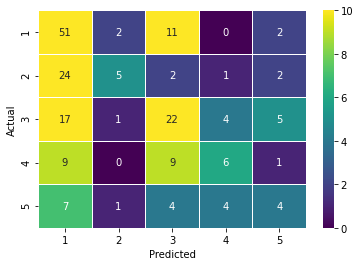

In [67]:
# Значения добавлены, чтобы оценить нужно ли моделировать пустые значения
print('Benchmark F1 (random): \t\t', f1_score(z_test,
                                              np.random.randint(1, 6, len(z_test)), 
                                              average='weighted'))
print('Benchmark F1 (most common): \t', f1_score(z_test, 
                                                 [train.education.value_counts().index[0]] * len(z_test), 
                                                 average='weighted'))
print()

for k in edu_models.keys():
    model = edu_models[k]['model']
    hyperparameters = edu_models[k]['params']
    print(model)
    
    # Поик оптимальных параметров для каждой модели с точки зрения F1 score
    gscv = GridSearchCV(model, hyperparameters, cv=5, verbose=0, 
                        scoring='f1_weighted')
    search = gscv.fit(W_train, z_train)
    pred = search.best_estimator_.predict(W_test)
    
    #  Предсказание тестовой выборки моделями
    print('Лучшие параметры: \t\t', search.best_params_)
    print('F1 score: \t\t\t', f1_score(
        z_test, pred, average='weighted'))
    print('Confusion matrix:')
    matrix = pd.DataFrame(confusion_matrix(z_test, pred), 
                          columns=[i for i in range(1, 6)], 
                          index = [i for i in range(1, 6)])
    sns.heatmap(matrix, vmin=0, 
                vmax=10, annot=True, linewidths=.5, cmap='viridis')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Добавление оптимальных моделей в словарь
    edu_models[k]['best_model'] = search.best_estimator_

Из протестированных алгоритмов, наилучшим образом себя показывает DecisionTreeClassifier.

Чтобы убедиться, что относительное качество моделей не характерно лишь для тестовой выборки, имеет смысл воспользоваться также валидационной.

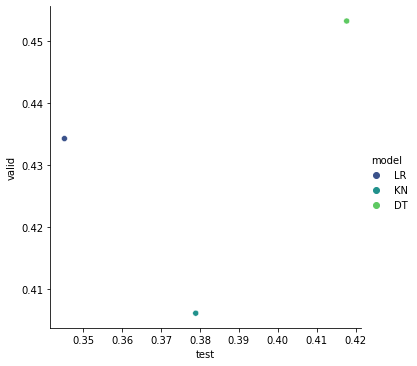

In [68]:
# Смотрим F1 score для тестовой и валидационной выборки
edu_F1_test = []
edu_F1_valid = []

for k in edu_models.keys():
    model = edu_models[k]['best_model']
    edu_F1_test.append(f1_score(z_test, model.predict(W_test), average='weighted'))
    edu_F1_valid.append(f1_score(z_valid, model.predict(W_valid), average='weighted'))

edu_F1 = pd.DataFrame({'test':edu_F1_test, 'valid':edu_F1_valid, 'model':edu_models.keys()})
sns.relplot(data=edu_F1, x='test', y='valid', hue='model', palette = 'viridis')

DecisionTreeClassifier так же лучше на валидации.

Для заполнения пропусков будет использована:

In [69]:
edu_models['DT']['best_model']

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)

### Применение модели

In [70]:
# Выбираем данные с пропущенным 'education'
edu_na_sample = train[train.education.isna() == True].drop('education', axis = 1)

In [71]:
# Предобработка признаков
W_na_cat = edu_OHE.transform(edu_na_sample[edu_cat_cols].values)
W_na_num = edu_SS.transform(edu_na_sample[edu_num_cols].values)
W_na = np.hstack([W_na_num, edu_na_sample[edu_bin_cols].values, W_na_cat])

In [72]:
# Применение модели
edu_model = edu_models['DT']['best_model']
edu_model.fit(W, z)
edu_predictions = pd.Series(edu_model.predict(W_na), index = train[train.education.isna() == True].index)

In [73]:
# Функция возвращает 1, если ячейка в формате 'int' пуста
def isna(cell):
    if cell%1 != 0:
        return 1
    else:
        return 0 

In [74]:
# Функция возвращает предсказание для пропущенного значения
def filling(row):
    if row['edu_isna'] == 1:
        return edu_predictions[row.name]
    else:
        return row['education']

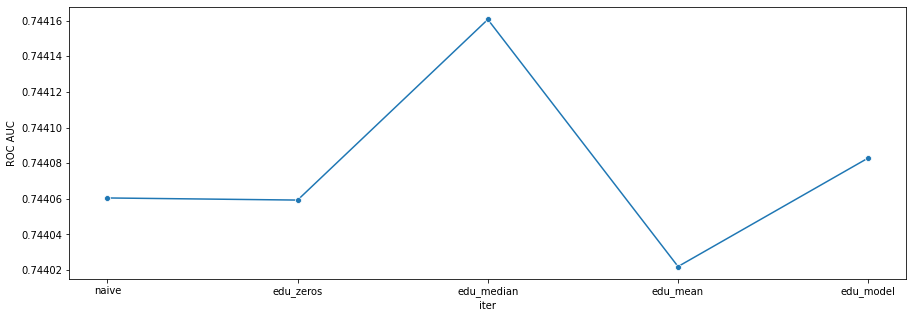

,naive,edu_zeros,edu_median,edu_mean,edu_model
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932
Precision,0.405941,0.405941,0.411765,0.410000,0.407767
Recall,0.022441,0.022441,0.022989,0.022441,0.022989
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523


In [75]:
edu_modeling = train.copy()
edu_modeling['edu_isna'] = edu_modeling.education.apply(isna)
edu_modeling['education'] = edu_modeling.apply(filling, axis = 1)
results['edu_model'] = metics(edu_modeling, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

## Итог

Наилучшим образом себя показывает заполнение медианой. Не смотря на то, что по остальным метрикам моделирование идентично заполнению медианой, данный способ снижает целевую метрику ROC AUC. 

In [76]:
train['education'].fillna(train['education'].median(), inplace=True)

# Feature Engineering

<AxesSubplot:>

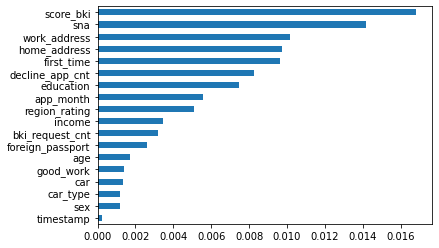

In [77]:
# Расчет взаимной иформации
features = train.copy().drop('default', axis = 1)
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Timestamp почти не содерщит общей информации с целевой переменной. Можно попробовать удалить данный параметр.

In [78]:
num_cols.remove('timestamp')

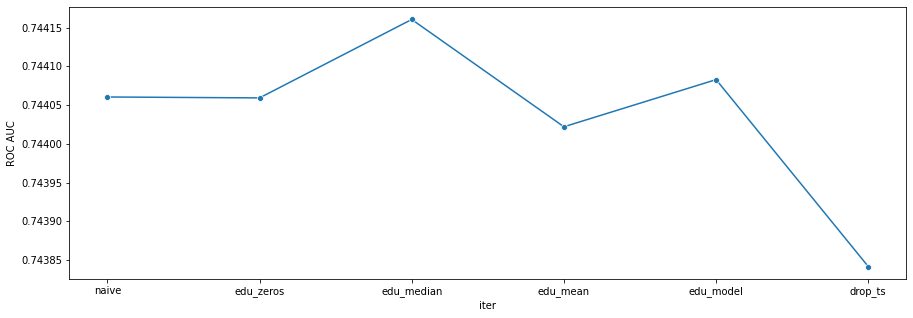

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583


In [79]:
drop_ts = train.drop('timestamp', axis=1)
results['drop_ts'] = metics(drop_ts, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Удаление timestamp ухудшает работу модели с точки зрения всех метрик кроме Accuracy.

In [80]:
num_cols.append('timestamp')

## Clusters
Unsupervised ML способен разбить данные на кластеры, для которых закономерности отличаются.

Параметры выбраны произвольно.

In [81]:
# Отбираем признаки с MI score > 0.005
cluster_cols = mi_test(features.columns, 0.005)
cluster_cols

['education',
 'decline_app_cnt',
 'score_bki',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'app_month']

In [82]:
# Применение кластеризации
kmeans = KMeans(n_clusters=5, max_iter = 1500, n_init = 20, random_state = RS)
CSS = StandardScaler()
CSS.fit(train[cluster_cols].values)
kmeans.fit(CSS.transform(train[cluster_cols].values))
train["cluster"] = kmeans.predict(CSS.transform(train[cluster_cols].values))

In [83]:
train.sample(3)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_month,timestamp,cluster
7236,2.0,1,3.060851,1,1,1,1,-1.772072,0.000000,0.5,1,3,5.841720,2,2,0,0,1,1391126400,2
59461,3.0,0,3.228933,0,0,0,1,-1.262311,1.457966,0.5,2,3,5.693645,1,4,0,1,2,1391212800,3
35069,1.0,0,3.669663,0,0,0,0,-2.838435,0.663986,0.4,2,3,5.381292,2,3,0,0,3,1395187200,3


CLUSTER
0 (%%):	0.3
	 Среднее значение целевой:	0.08
3 (%%):	0.21
	 Среднее значение целевой:	0.13
1 (%%):	0.17
	 Среднее значение целевой:	0.06
4 (%%):	0.16
	 Среднее значение целевой:	0.21
2 (%%):	0.15
	 Среднее значение целевой:	0.2
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

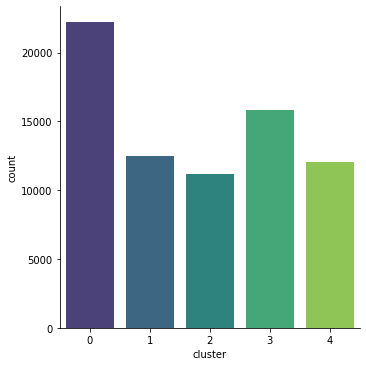

In [84]:
sum_up_cat(train, 'cluster', 'default')

In [85]:
cat_cols.append('cluster')

<AxesSubplot:>

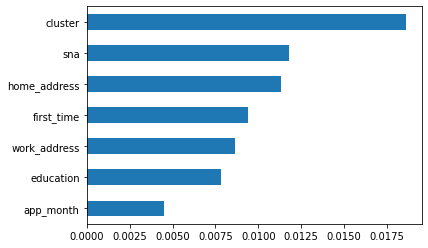

In [86]:
# Расчет взаимной иформации
features = train[cat_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

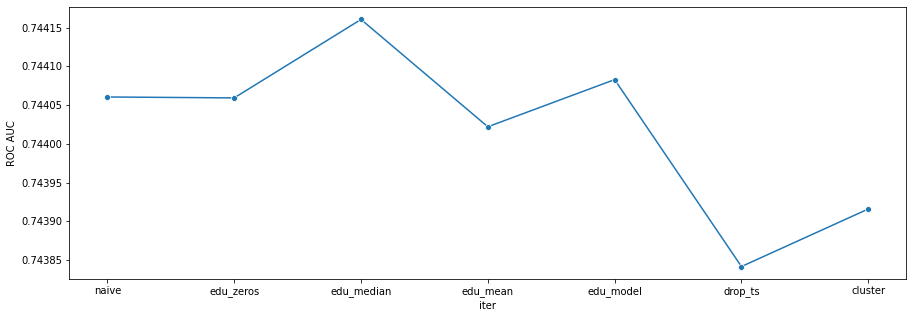

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541


In [87]:
cluster = train.copy()
results['cluster'] = metics(cluster, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Кластеризация значительно снизила ROC AUC. Остальные метрики также снизились.

In [88]:
cat_cols.remove('cluster')
train.drop('cluster', axis=1, inplace=True)

## PCA

In [89]:
# Стандартизация числовых переменных, выделение целевой
A = StandardScaler().fit_transform(train[num_cols].values)
b = train.default

In [90]:
# Применение метода главных компанет
pca = PCA(random_state = RS)
A_pca = pca.fit_transform(A)
component_names = [f"PC{i+1}" for i in range(A_pca.shape[1])]

A_pca = pd.DataFrame(A_pca, columns=component_names)
A_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.489047,0.080595,0.339226,1.381956,0.664542,-0.029471
1,1.097981,0.900151,1.273215,0.052216,0.828360,0.042784
2,-1.802845,0.607494,-1.409473,0.188500,0.490279,1.096231
3,1.845447,0.646443,0.108447,1.288107,0.130398,0.890167
4,-0.021199,0.129554,0.771134,-1.152885,1.615480,-0.262676


<AxesSubplot:>

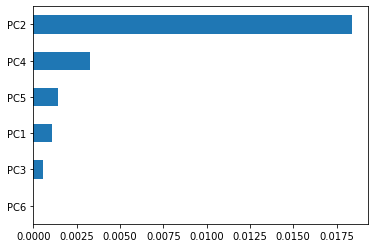

In [91]:
# Оцентка компанент
mi_scores = mutual_info_classif(A_pca, b, random_state = RS)
mi_scores = pd.Series(mi_scores, index=A_pca.columns)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Наибольшую ценность представляет компанета 'PC2'. Остальные можно спокойно отсеять, чтобы не увеличивать шум в данных.

In [92]:
# Голова и хвост выборки, упорядоченной по 'PC2'
idx = A_pca['PC2'].sort_values(ascending=False).index
cols = num_cols

display(train.loc[idx, cols].head(10))
display(train.loc[idx, cols].tail(10))

,age,score_bki,bki_request_cnt,income,region_rating,timestamp
55405,3.060851,-0.223299,2.986413,5.708736,0.5,1391731200
33206,3.466398,-0.481892,3.043123,5.620854,0.5,1389139200
67718,3.060851,-0.702280,3.056436,5.829463,0.5,1391385600
47584,2.975565,-0.356936,2.297558,5.841720,0.5,1390003200
23064,2.975565,-0.484254,2.499029,5.560409,0.6,1390348800
35787,2.844680,-0.097323,1.727453,5.820880,0.5,1389916800
6657,2.808159,-0.348961,1.727453,5.560409,0.5,1388966400
71115,2.879550,-0.042827,1.921474,5.771906,0.6,1390694400
34067,3.496999,-0.263199,2.072081,5.460064,0.5,1390348800
14861,3.207100,-0.680085,2.499029,5.560409,0.5,1389484800


,age,score_bki,bki_request_cnt,income,region_rating,timestamp
16158,3.466398,-2.983168,0.0,5.685706,0.8,1398643200
67954,3.645626,-3.079144,0.0,5.742558,0.8,1396483200
39648,3.310398,-3.138558,0.0,5.908964,0.8,1396224000
12846,3.383819,-3.088781,0.0,6.024986,0.8,1395964800
7819,3.657744,-3.174842,0.0,5.713074,0.7,1397433600
61365,3.450606,-2.959679,0.0,6.016880,0.8,1397779200
34405,3.401091,-3.145981,0.0,5.797779,0.8,1397952000
13195,3.450606,-3.339817,0.0,5.878065,0.7,1396742400
61176,3.348017,-3.420154,0.0,5.609927,0.8,1397088000
34773,3.366134,-3.624586,0.0,5.841720,0.8,1398643200


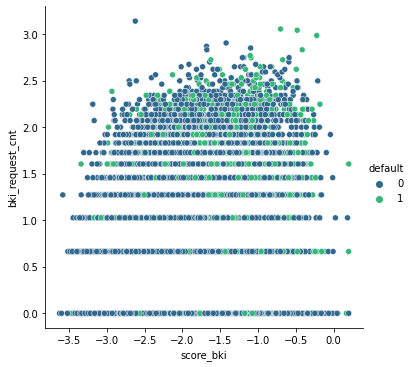

In [93]:
sns.relplot(data=train, x='score_bki', y='bki_request_cnt', hue='default', palette = 'viridis')

<AxesSubplot:ylabel='score_bki'>

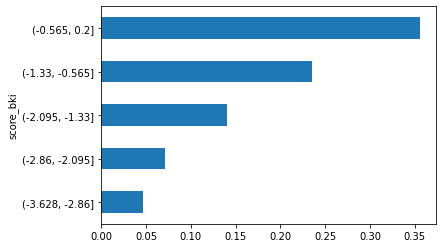

In [94]:
# Риск дефолта для категорий 'score_bki'
bins = pd.cut(train['score_bki'], bins=5)
train.groupby(bins).default.mean().plot(kind = 'barh')

<AxesSubplot:ylabel='bki_request_cnt'>

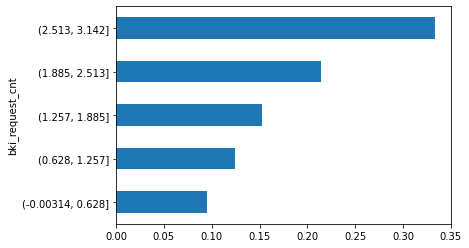

In [95]:
# Риск дефолта для категорий 'bki_request_cnt'
bins = pd.cut(train['bki_request_cnt'], bins=5)
train.groupby(bins).default.mean().plot(kind = 'barh')

Визуально, большее кол-во дефолтов характерно для клиентов с 'score_bki' близким к 0, и высоким 'bki_request_cnt'. Таким образом, новая переменная 'bki_ovrl' должна расти вместе с имеющимися.

Для этого, для 'score_bki' имеет смысл сместить минимум в 0. После чего полученный рейтинг будет помножен на 'bki_request_cnt'. Таким образом, макимальное значение 'bki_ovrl' достигается при большом количестве запросов в БКИ и плохом, с точки зрения риска дефоолта, рейтинге. Иными словами, метрика отбражает подтвержденный (многими запросами) плохой рейтинг заемщика.
(Расчет метрики через sin/cos 45 дает худший результат).

In [96]:
# Создание переменной
pca = train.copy()
pca['bki_ovrl'] = (pca.score_bki - pca.score_bki.min())*pca.bki_request_cnt.values
num_cols.append('bki_ovrl')

<AxesSubplot:>

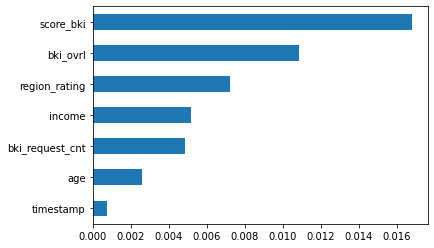

In [97]:
# Расчет взаимной иформации
features = pca[num_cols].copy()
target = pca.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

'bki_ovrl' показывает себя более полезной переменной, чем 'bki_request_cnt', но уступает 'score_bki'.

<AxesSubplot:>

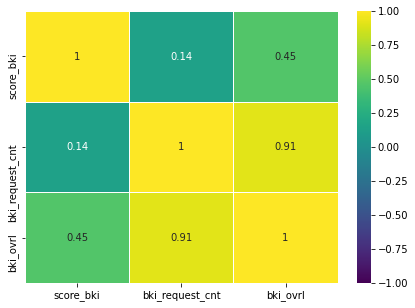

In [98]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(7, 5))
sns.heatmap(pca[['score_bki','bki_request_cnt','bki_ovrl']].corr(), vmin=-1, 
            vmax=1, annot=True, linewidths=.5, cmap='viridis')

Корреляция между 'bki_ovrl' и 'bki_score' не привышает 0.5, в то время как корреляция с 'bki_request_cnt' слишком высока. Так как 'bki_ovrl' обладает большей общей информацией с 'default', 'bki_request_cnt' будет удален.

In [99]:
pca.drop('bki_request_cnt', axis = 1, inplace = True)
num_cols.remove('bki_request_cnt')

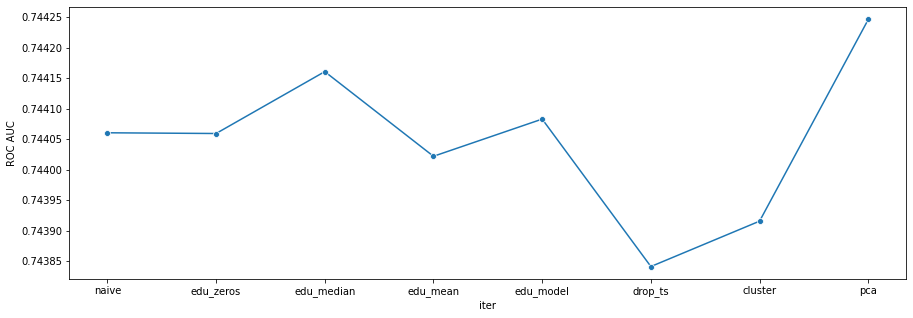

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429


In [100]:
results['pca'] = metics(pca, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Созданный признак 'bki_ovrl' улучшил работу модели

In [101]:
train['bki_ovrl'] = (train.score_bki - train.score_bki.min())*train.bki_request_cnt.values
train.drop('bki_request_cnt', axis = 1, inplace = True)

## Создание переменных на основе логики

### reliable_cust

Переменная на основе давности наличия информации о заемщике ('first_time') и связи заемщика с клиентами банка ('sna')

FIRST_TIME
3 (%%):	0.42
	 Среднее значение целевой:	0.12
4 (%%):	0.25
	 Среднее значение целевой:	0.08
1 (%%):	0.17
	 Среднее значение целевой:	0.19
2 (%%):	0.16
	 Среднее значение целевой:	0.16
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

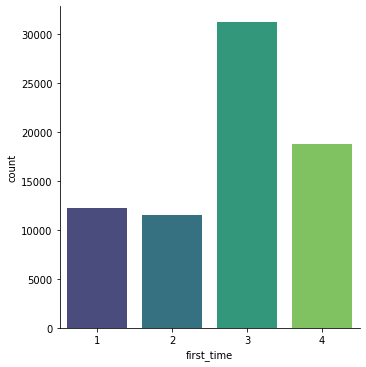

SNA
1 (%%):	0.64
	 Среднее значение целевой:	0.1
4 (%%):	0.16
	 Среднее значение целевой:	0.21
2 (%%):	0.14
	 Среднее значение целевой:	0.15
3 (%%):	0.06
	 Среднее значение целевой:	0.16
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

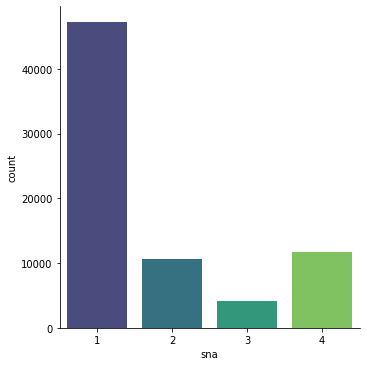

In [102]:
for col in ['first_time','sna']:
    sum_up_cat(train, col, 'default')

default rate уменьшается для 'first time' и увеличивается для 'sna'

RELIABLE_CUST
2 (%%):	0.32
	 Среднее значение целевой:	0.1
3 (%%):	0.23
	 Среднее значение целевой:	0.07
1 (%%):	0.15
	 Среднее значение целевой:	0.14
0 (%%):	0.1
	 Среднее значение целевой:	0.16
-3 (%%):	0.09
	 Среднее значение целевой:	0.2
-1 (%%):	0.08
	 Среднее значение целевой:	0.21
-2 (%%):	0.03
	 Среднее значение целевой:	0.19
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

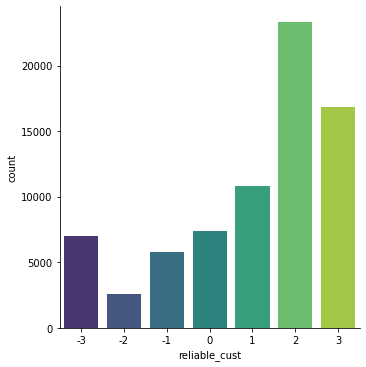

In [103]:
# Создание переменной
r_cust = train.copy()
r_cust['reliable_cust'] = r_cust.first_time - r_cust.sna

sum_up_cat(r_cust, 'reliable_cust', 'default')

In [104]:
cat_cols.append('reliable_cust')

<AxesSubplot:>

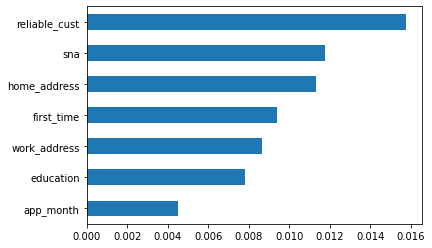

In [105]:
# Расчет взаимной иформации
features = r_cust[cat_cols].copy()
target = r_cust.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

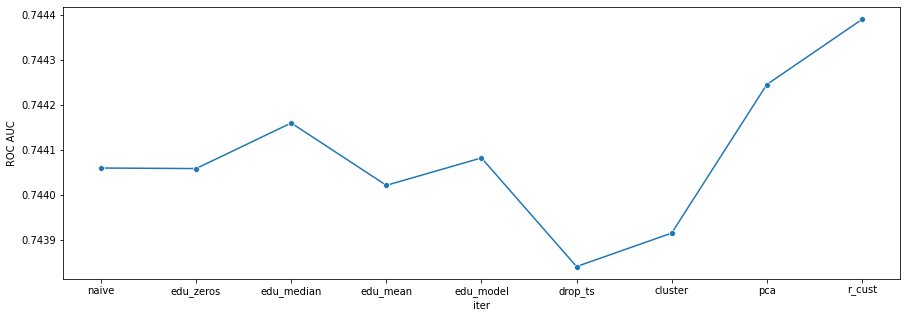

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554


In [106]:
results['r_cust'] = metics(r_cust, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Переменная 'reliable_cust' показывает MI score выше 0.01 и немного улучшает работу модели.

In [107]:
train['reliable_cust'] = train.first_time - train.sna

### travel_time

Переменная на основе домашнего адреса ('home_address') и адреса работы ('work_address'). Нет ясности как закодирован признак. Для дальнейшей работы, будем считать, что оба признака обозначают зоны удалености от определенной зоны (к примеру, центр города). В таком случае, разница по модулю между 'home_address' и 'work_address' обозначает частые перемещения между зонами.

TRAVEL_TIME
1 (%%):	0.79
	 Среднее значение целевой:	0.14
0 (%%):	0.14
	 Среднее значение целевой:	0.08
2 (%%):	0.07
	 Среднее значение целевой:	0.09
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

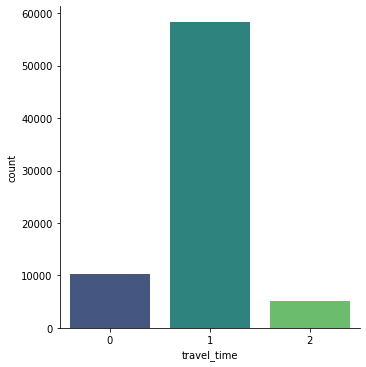

In [108]:
# Создание переменной
travel = train.copy()
travel['travel_time'] = travel.home_address - travel.work_address
travel['travel_time'] = travel.travel_time.apply(lambda x: -x if x<0 else x)

sum_up_cat(travel, 'travel_time', 'default')

In [109]:
cat_cols.append('travel_time')

<AxesSubplot:>

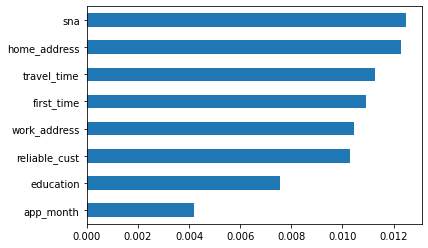

In [110]:
# Расчет взаимной иформации
features = travel[cat_cols].copy()
target = travel.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

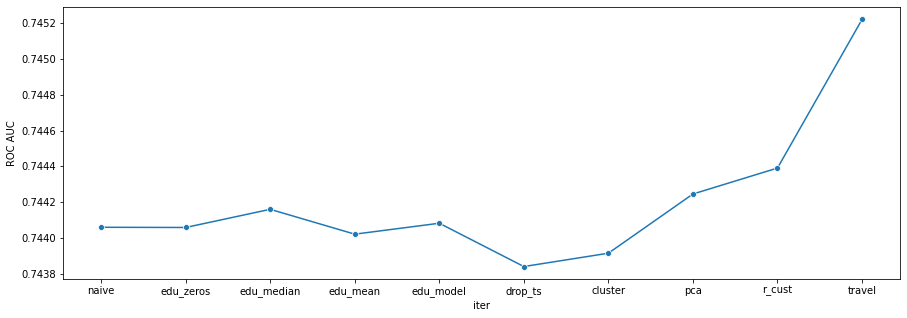

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust,travel
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391,0.745219
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203,0.875136
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193,0.432203
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725,0.027915
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554,0.052442


In [111]:
results['travel'] = metics(travel, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Переменная 'travel_time' показывает MI score выше 0.01 и заметно улучшает ROC AUC

In [112]:
train['travel_time'] = train.home_address - train.work_address
train['travel_time'] = train.travel_time.apply(lambda x: -x if x<0 else x)

### income_to_expenses

Переменная на основе дохода заемщика ('first_time') поделенная на кол-во потенциальных иточников трат на авто и заграничные поездки ('car', 'car_type', 'foreign_passport').

In [113]:
# Создание переменной
expenses = train.copy()
expenses['income_to_expenses'] = expenses.income/(1+expenses.car+expenses.car_type+expenses.foreign_passport)

INCOME_TO_EXPENSES
mean    4.272747
std     1.658575
min     1.285695
25%     2.780204
50%     5.479840
75%     5.661892
max     6.402578
Name: income_to_expenses, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



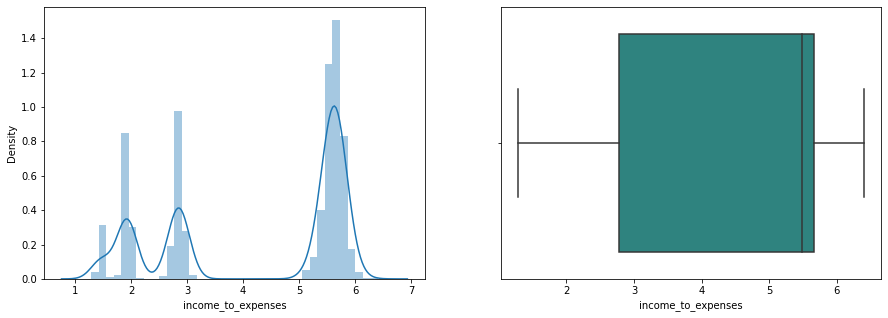

In [114]:
sum_up_num(expenses, 'income_to_expenses', 'default')

<AxesSubplot:>

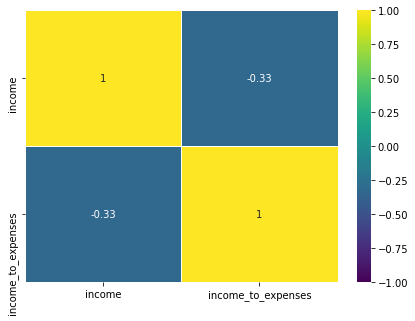

In [115]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(7, 5))
sns.heatmap(expenses[['income','income_to_expenses']].corr(), vmin=-1, 
            vmax=1, annot=True, linewidths=.5, cmap='viridis')

In [116]:
num_cols.append('income_to_expenses')

<AxesSubplot:>

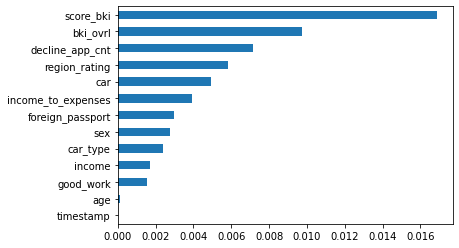

In [117]:
# Расчет взаимной иформации
features = expenses[bin_cols+num_cols].copy()
target = expenses.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

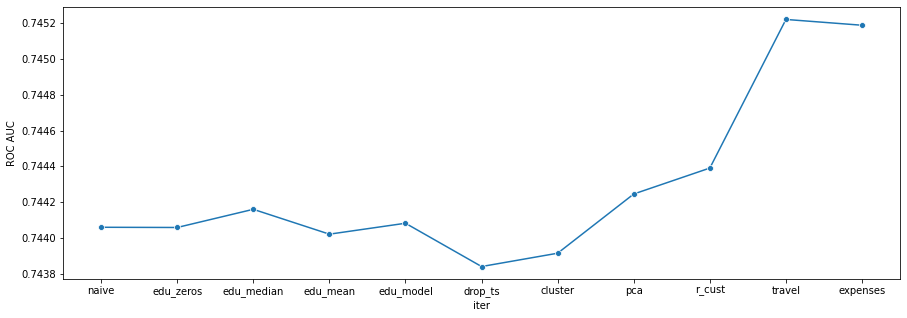

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust,travel,expenses
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391,0.745219,0.745187
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203,0.875136,0.875271
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193,0.432203,0.438596
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725,0.027915,0.027367
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554,0.052442,0.051520


In [118]:
results['expenses'] = metics(expenses, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Не смотря на то, что переменная 'income_to_expenses' показывает более высокий MI score и корреляция с 'income' в пределах нормы, точность подели снижается.

In [119]:
num_cols.remove('income_to_expenses')

### relative_edu

Переменная на основе уровня образования ('education') и возраста ('age') заемщика, и отображает относительный уровень образования

RELATIVE_EDU
mean   -0.989697
std     0.780506
min    -1.980020
25%    -1.723546
50%    -1.456545
75%    -0.119058
max     0.500661
Name: relative_edu, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



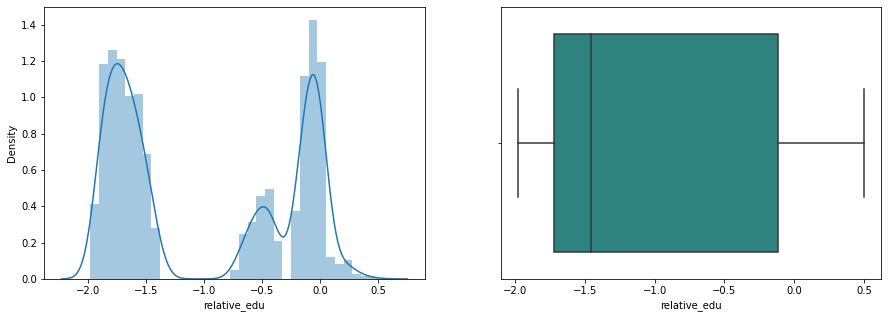

In [120]:
# Создание переменной
rel_edu = train.copy()
rel_edu['relative_edu'] = rel_edu.education/rel_edu.age
rel_edu['relative_edu'] = stats.boxcox(rel_edu['relative_edu'])[0]

sum_up_num(rel_edu, 'relative_edu', 'default')

<AxesSubplot:>

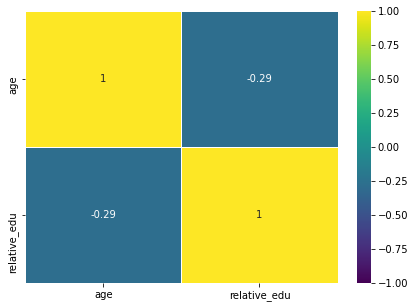

In [121]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(7, 5))
sns.heatmap(rel_edu[['age','relative_edu']].corr(), vmin=-1, 
            vmax=1, annot=True, linewidths=.5, cmap='viridis')

In [122]:
num_cols.append('relative_edu')

<AxesSubplot:>

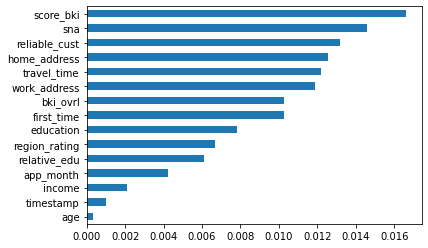

In [123]:
# Расчет взаимной иформации
features = rel_edu[cat_cols+num_cols].copy()
target = rel_edu.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

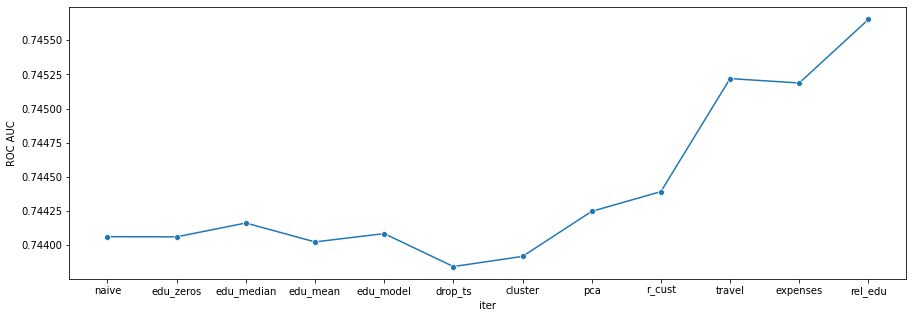

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust,travel,expenses,rel_edu
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391,0.745219,0.745187,0.745653
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203,0.875136,0.875271,0.875203
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193,0.432203,0.438596,0.433628
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725,0.027915,0.027367,0.026820
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554,0.052442,0.051520,0.050515


In [124]:
results['rel_edu'] = metics(rel_edu, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Не смотря на то, что 'relative_edu' не дает прибавки в общей информации по сравнению с 'education', ROC AUC для модели повысился.

In [125]:
train['relative_edu'] = train.education/train.age
train['relative_edu'] = stats.boxcox(train['relative_edu'])[0]

## Создание агрегированных переменных путем перекодировки

### bin_cat_rating

Рейтинг на основе бинарных и категориальных переменных. За основу взята линейная зависимость между значениями признака и default rate. Из суммы переменных с положинельной линейной зависимостью вычетаются переменные с отрицательной линейной зависимостью. Категория 'home_address' не включена, т. к. в этом случае линейная зависимость отсутствует.

BIN_CAT_RATING
mean    10.122793
std      3.028799
min      1.000000
25%      8.000000
50%     10.000000
75%     12.000000
max     20.000000
Name: bin_cat_rating, dtype: float64
Кол-во выбросов: 89 	 (%%: 0.12)



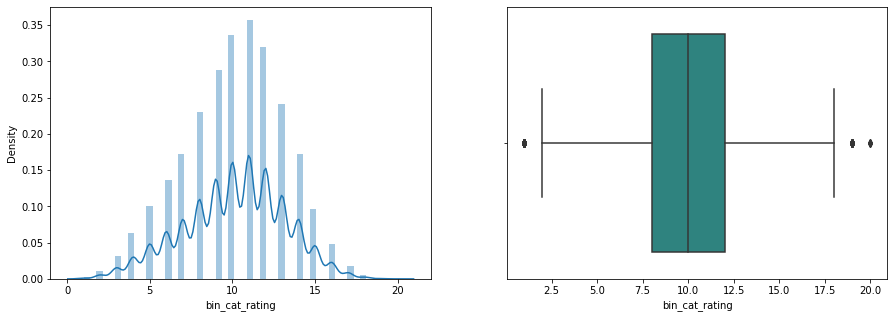

In [126]:
# Создание переменной
bin_cat = train.copy()
bin_cat['bin_cat_rating'] = bin_cat[['car', 'car_type', 'good_work', 
                                 'foreign_passport', 'education', 
                                 'first_time', 'app_month']].sum(axis=1) - bin_cat[['sex', 'decline_app_cnt', 
                                                                                  'work_address', 'sna']].sum(axis=1)
# Необязательный сдвиг переменной, чтобы рейтинг был от 1го до 20ти
bin_cat['bin_cat_rating'] = bin_cat['bin_cat_rating'] + 7

sum_up_num(bin_cat, 'bin_cat_rating', 'default')

<AxesSubplot:>

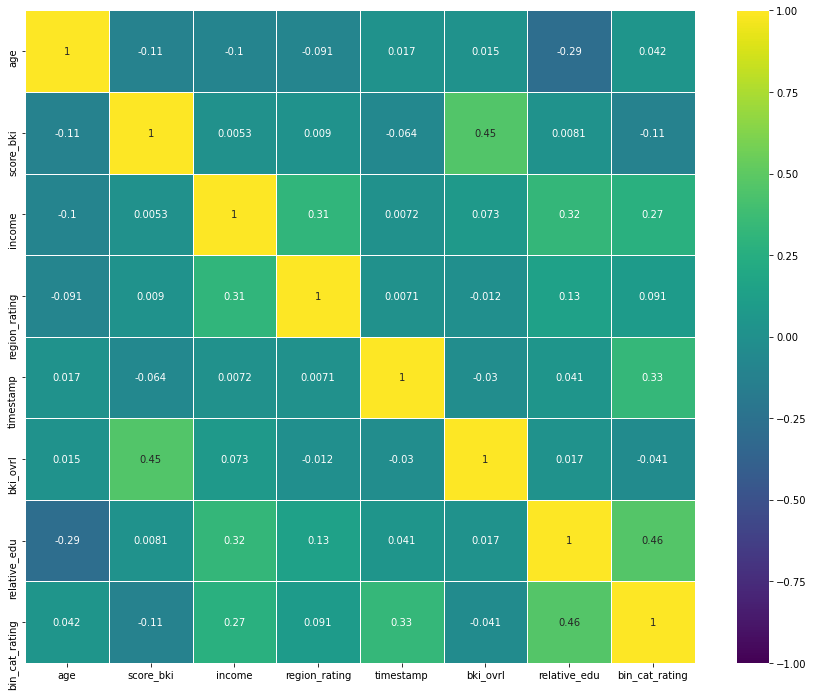

In [127]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(bin_cat[num_cols+['bin_cat_rating']].corr(), vmin=-1, 
            vmax=1, annot=True, linewidths=.5, cmap='viridis')

In [128]:
num_cols.append('bin_cat_rating')

<AxesSubplot:>

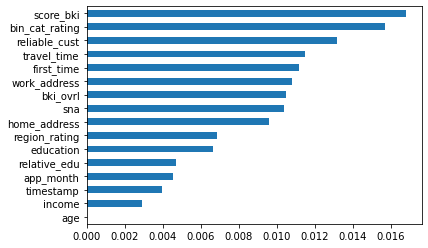

In [129]:
# Расчет взаимной иформации
features = bin_cat[cat_cols+num_cols].copy()
target = bin_cat.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

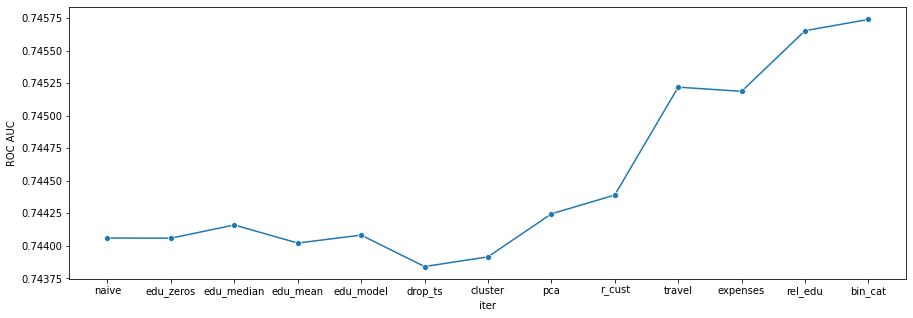

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust,travel,expenses,rel_edu,bin_cat
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391,0.745219,0.745187,0.745653,0.745739
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203,0.875136,0.875271,0.875203,0.875068
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193,0.432203,0.438596,0.433628,0.426087
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725,0.027915,0.027367,0.026820,0.026820
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554,0.052442,0.051520,0.050515,0.050463


In [130]:
results['bin_cat'] = metics(bin_cat, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Переменная 'bin_cat_rating' показывает  относительно высокий MI score. При этом, корреляция со 'score_bki' (вторым по полезности признаком) низкая. Распределение переменной нормально. Имеется незначительное кол-во выбросов. Есть небольшое улучшение модели.

In [131]:
train['bin_cat_rating'] = train[['car', 'car_type', 'good_work', 
                                 'foreign_passport', 'education', 
                                 'first_time', 'app_month']].sum(axis=1) - train[['sex', 'decline_app_cnt', 
                                                                                  'work_address', 'sna']].sum(axis=1)
train['bin_cat_rating'] = train['bin_cat_rating'] + 7

### num_category

Переменная на основе числовых данных (age','income','region_rating','score_bki'). За основу взята разница в средних значениях для дефолтных и недефолтных клиентов. Каждое значение сравнивается с медианой признака. Если значение попадает в половину с более низким default rate, клиент повышается в классе.

In [132]:
# Вспомогательный справочник для быстродействия num_transform со средними значениями числовых признаков
nt_help = pd.Series([1.0,1.0,1.0,1.0], index = ['age','income','region_rating','score_bki'], name = 'Medians')
for i in nt_help.index:
    nt_help.loc[i] = train[i].median()
nt_help

age              3.228933
income           5.668952
region_rating    0.500000
score_bki       -1.920823
Name: Medians, dtype: float64

In [133]:
# Функция возвращает значение 'num_category' для строки
def num_transform(raw):
    count = 0
    for col in ['age','income','region_rating']:
        if raw[col] > nt_help[col]:
            count += 1
    if raw['score_bki'] < nt_help['score_bki']:
        count += 1
    return count

NUM_CATEGORY
2 (%%):	0.36
	 Среднее значение целевой:	0.12
1 (%%):	0.27
	 Среднее значение целевой:	0.17
3 (%%):	0.22
	 Среднее значение целевой:	0.08
0 (%%):	0.09
	 Среднее значение целевой:	0.22
4 (%%):	0.06
	 Среднее значение целевой:	0.05
Cтатистически значимые различия:	True


<Figure size 432x288 with 0 Axes>

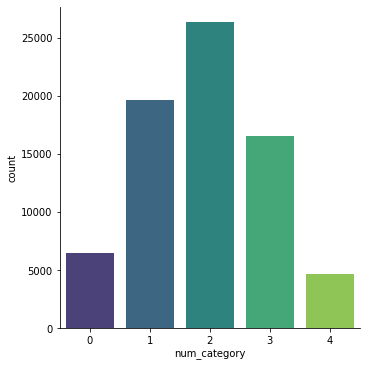

In [134]:
# Создание переменной
num = train.copy()
num['num_category'] = num.apply(num_transform, axis = 1)

sum_up_cat(num, 'num_category', 'default')

In [135]:
cat_cols.append('num_category')

<AxesSubplot:>

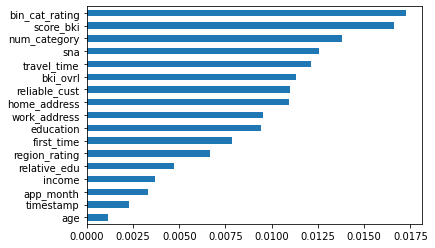

In [136]:
# Расчет взаимной иформации
features = num[cat_cols+num_cols].copy()
target = num.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

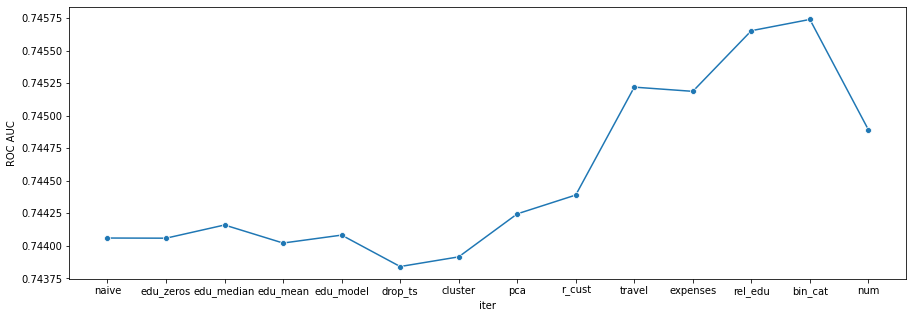

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust,travel,expenses,rel_edu,bin_cat,num
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391,0.745219,0.745187,0.745653,0.745739,0.744892
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203,0.875136,0.875271,0.875203,0.875068,0.875000
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193,0.432203,0.438596,0.433628,0.426087,0.421053
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725,0.027915,0.027367,0.026820,0.026820,0.026273
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554,0.052442,0.051520,0.050515,0.050463,0.049459


In [137]:
results['num'] = metics(num, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

Не смотря на то, что переменная показывает высокий MI score, качество модели заметно снизилось.

In [138]:
cat_cols.remove('num_category')

## Polynominals

Так как для моделирования будет использована логистическая регрессия, то есть сигмоида, где в степени знаменателя линейная функция, имеет смысл составить полиноминалы для отражения нелинейного воздействия числовых переменных.

Полиминалы будут строиться и отбираться вручную, так как банковский скоринг подразумевает интерпретируемость результов.

### Степени

In [139]:
# Фиксируем числовые переменные на начало эксперимента
num_cols_help = num_cols

In [140]:
# Создаем полиноминалы 2ой, 3ей и -1ой степеней во вспомогательном DataFrame
poly = train.copy()
degrees = []
for col in num_cols:
    for degree in [2,3]:
        name = '{}^{}'.format(col, degree)
        poly[name] = poly[col]**degree
        degrees.append(name)
    name  = '1/{}'.format(col)
    poly[name] = 1/(poly[col]+1)
    degrees.append(name)

In [141]:
# Функция возвращает список колонок, которые при индивидуальном тестировании дали 
# прибавку в ROC AUC
def improvements(cols, main_df, help_df, best_score):
    poly_improvement = {}
    for col in cols:
        test = main_df.copy()
        num_cols.append(col)
        test[col] = help_df[col]
        poly_improvement[col] = metics(test, 'default')[0] - best_score
        num_cols.remove(col)
    
    useful_features = []
    for key in poly_improvement.keys():
        if poly_improvement[key]>0:
            useful_features.append(key)
    return useful_features

In [142]:
useful_features = improvements(degrees, train, poly, results.loc['ROC AUC'].max())
useful_features

['age^2',
 'age^3',
 '1/age',
 'income^2',
 'income^3',
 '1/income',
 'region_rating^2',
 'region_rating^3',
 '1/region_rating',
 'timestamp^3',
 'bki_ovrl^2',
 'bki_ovrl^3',
 '1/bki_ovrl',
 'relative_edu^2',
 'bin_cat_rating^2',
 '1/bin_cat_rating']

In [143]:
# Функция возвращает результат последовательного добавления признаков в основной DataFrame
def progress(cols, main_df, best_score):
    test = main_df.copy()
    results = {}
    for col in cols:
        num_cols.append(col)
        test[col] = poly[col]
        results[col]=metics(test, 'default')[0]

    for col in cols:
        num_cols.remove(col)
    return results

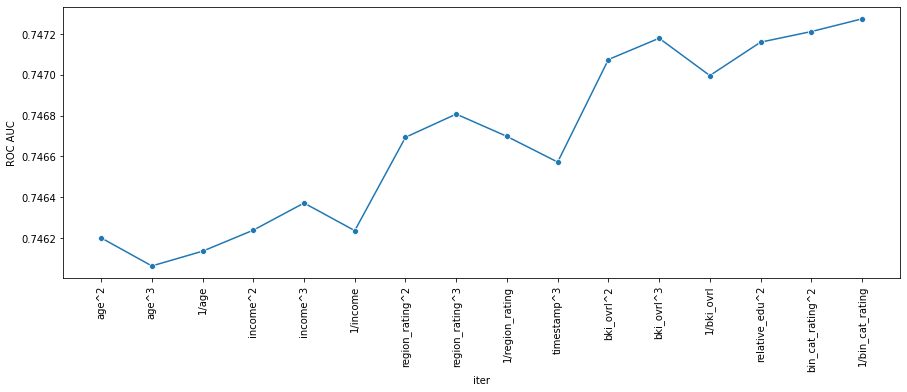

In [144]:
# Визуализация результата
testing_results = progress(useful_features, train, results.loc['ROC AUC'].max())

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=np.array(list(testing_results.keys())), y=testing_results.values(), marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.xticks(list(testing_results.keys()), rotation='vertical')
plt.show()

In [145]:
# Удаление признаков, ухудшающих модель после последовательного присоединения
def optimize(test_res, main_df, best_score):
    while True:
        result = list(test_res.values())
        cols = list(test_res.keys())
        to_delete = []
        for i in range(1, len(cols)):
            if result[i]<result[i-1]:
                to_delete.append(cols[i])
        if len(to_delete)>0:
            for col in to_delete:
                cols.remove(col)
            test_res = progress(cols, main_df, best_score)
        else:
            return cols
            break

In [146]:
degree_features = optimize(testing_results, train, results.loc['ROC AUC'].max())
degree_features

['age^2',
 '1/age',
 'income^2',
 'income^3',
 'region_rating^2',
 'region_rating^3',
 'bki_ovrl^2']

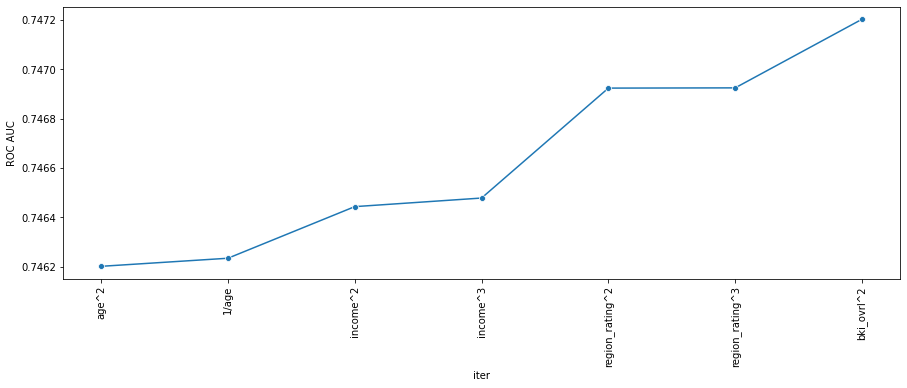

In [147]:
# Повторная визуализация результата
testing_results = progress(degree_features, train, results.loc['ROC AUC'].max())

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=np.array(list(testing_results.keys())), y=testing_results.values(), marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.xticks(list(testing_results.keys()), rotation='vertical')
plt.show()

В итоге, ROC AUC растет на протяжении прсоединения признаков, которых стало значительно меньше.

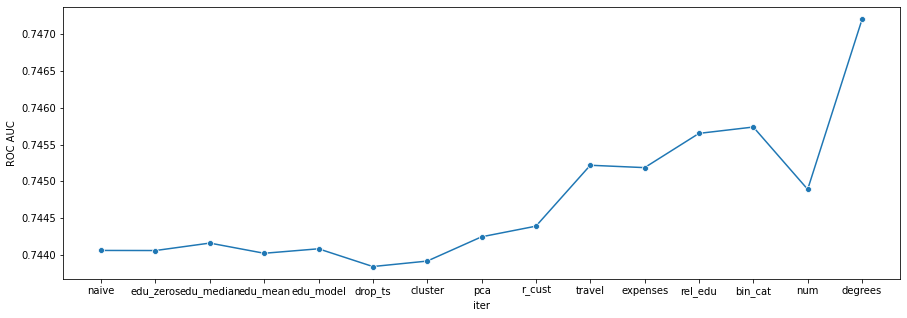

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust,travel,expenses,rel_edu,bin_cat,num,degrees
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391,0.745219,0.745187,0.745653,0.745739,0.744892,0.747203
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203,0.875136,0.875271,0.875203,0.875068,0.875000,0.875474
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193,0.432203,0.438596,0.433628,0.426087,0.421053,0.452174
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725,0.027915,0.027367,0.026820,0.026820,0.026273,0.028462
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554,0.052442,0.051520,0.050515,0.050463,0.049459,0.053553


In [148]:
# Добавление в основной DataFrame
num_cols = num_cols+degree_features
for feature in degree_features:
    train[feature] = poly[feature]

# Визуализация
results['degrees'] = metics(train, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

### Произведения

In [149]:
# Создаем произведения числовых переменных во вспомогательном DataFrame
multiply = []
for pair in list(combinations(num_cols_help, 2)):
    name = '{}*{}'.format(pair[0],pair[1])
    poly[name] = poly[pair[0]]*poly[pair[1]]
    multiply.append(name)

In [150]:
useful_features = improvements(multiply, train, poly, results.loc['ROC AUC'].max())
useful_features

['age*income',
 'age*region_rating',
 'score_bki*bin_cat_rating',
 'income*region_rating',
 'timestamp*relative_edu',
 'timestamp*bin_cat_rating',
 'bki_ovrl*bin_cat_rating']

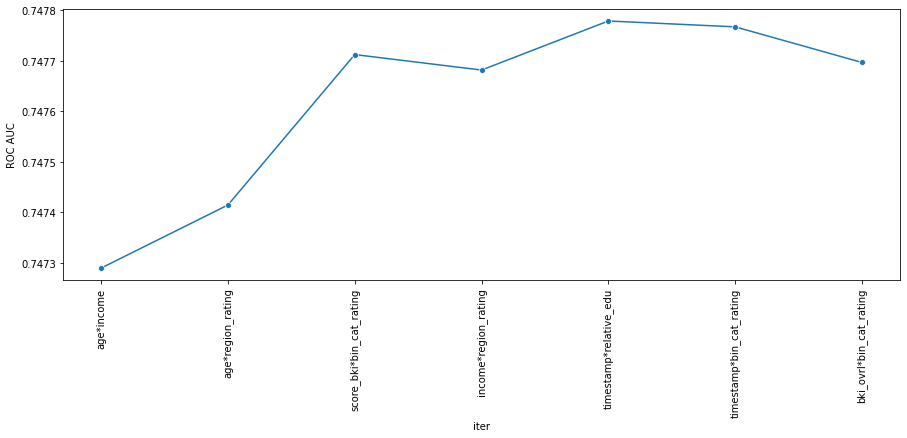

In [151]:
# Визуализация результата
testing_results = progress(useful_features, train, results.loc['ROC AUC'].max())

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=np.array(list(testing_results.keys())), y=testing_results.values(), marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.xticks(list(testing_results.keys()), rotation='vertical')
plt.show()

In [152]:
multiply_features = optimize(testing_results, train, results.loc['ROC AUC'].max())
multiply_features

['age*income', 'age*region_rating', 'score_bki*bin_cat_rating']

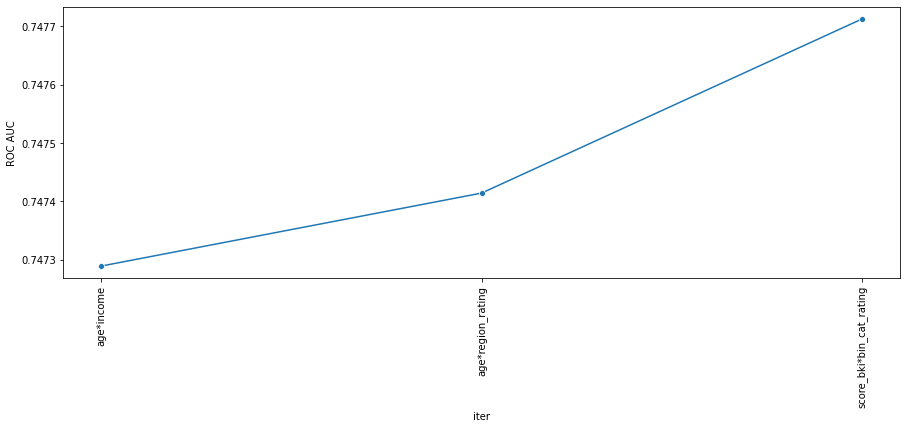

In [153]:
# Повторнизуализация результата
testing_results = progress(multiply_features, train, results.loc['ROC AUC'].max())

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=np.array(list(testing_results.keys())), y=testing_results.values(), marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.xticks(list(testing_results.keys()), rotation='vertical')
plt.show()

В итоге, ROC AUC растет на протяжении прсоединения признаков, которых стало значительно меньше.

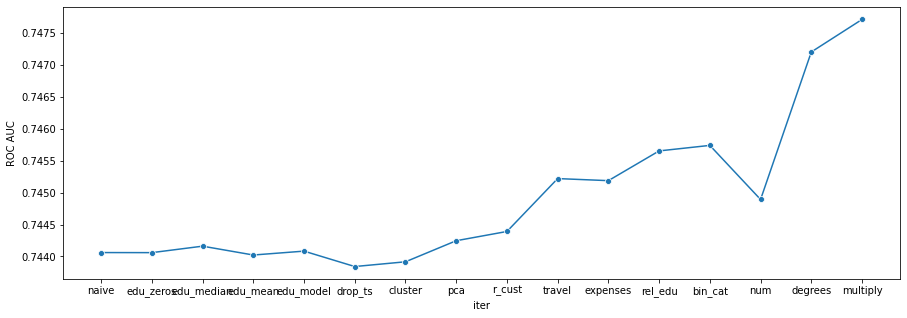

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust,travel,expenses,rel_edu,bin_cat,num,degrees,multiply
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391,0.745219,0.745187,0.745653,0.745739,0.744892,0.747203,0.747712
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203,0.875136,0.875271,0.875203,0.875068,0.875000,0.875474,0.875949
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193,0.432203,0.438596,0.433628,0.426087,0.421053,0.452174,0.477273
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725,0.027915,0.027367,0.026820,0.026820,0.026273,0.028462,0.022989
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554,0.052442,0.051520,0.050515,0.050463,0.049459,0.053553,0.043864


In [154]:
# Добавление в основной DataFrame
num_cols = num_cols+multiply_features
for feature in multiply_features:
    train[feature] = poly[feature]

# Визуализация
results['multiply'] = metics(train, 'default')

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

## Итог

<AxesSubplot:>

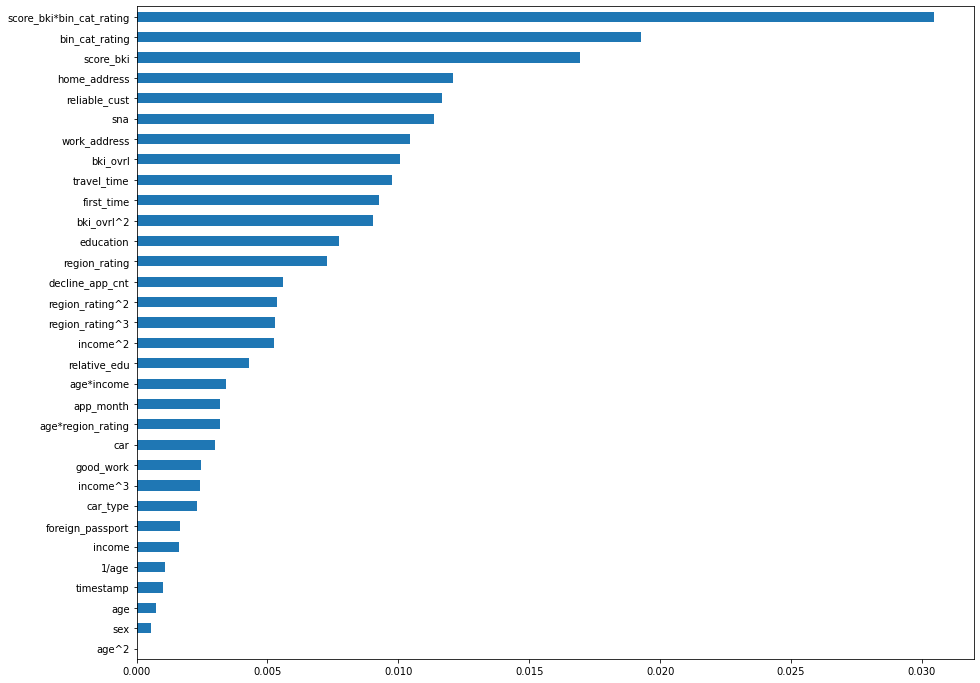

In [155]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+bin_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh', figsize=(15, 12))

In [156]:
train.sample(3)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,region_rating,home_address,...,age^2,1/age,income^2,income^3,region_rating^2,region_rating^3,bki_ovrl^2,age*income,age*region_rating,score_bki*bin_cat_rating
21058,3.0,1,3.087277,0,0,0,0,-2.115111,0.4,1,...,9.531281,0.244662,32.137022,182.183251,0.16,0.064,0.000000,17.501628,1.234911,-25.381338
41439,1.0,1,3.310398,1,0,0,0,-1.744715,0.5,2,...,10.958737,0.231997,32.589669,186.045827,0.25,0.125,1.558022,18.898191,1.655199,-10.468291
28521,1.0,0,3.060851,0,0,0,1,-1.446761,0.5,2,...,9.368806,0.246254,33.614242,194.887945,0.25,0.125,2.091046,17.746135,1.530425,-14.467606


В ходе обработки признаков, удалось повысить целовую метрику. Так же, синтетический признак 'score_bki*bin_cat_rating', имеет наибольшую общую информацию с целевой переменной.

# Model

In [157]:
# Создание предобработок данных
main_OHE = OneHotEncoder(sparse = False).fit(train[cat_cols].values)
main_SS = StandardScaler().fit(train[num_cols].values)

In [158]:
# Предобработка
X_cat = main_OHE.transform(train[cat_cols].values)
X_num = main_SS.transform(train[num_cols].values)
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [159]:
# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = RS)

In [160]:
# Создание модели
model = LogisticRegression(random_state = RS)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

### ROC AUC

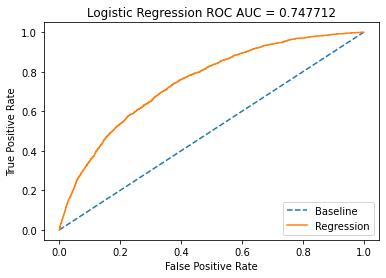

In [161]:
# Рассчет и визуализация ROC AUC
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Дополнительные метрики

Accuracy: 		 0.8759
Precision: 		 0.4773
Recall: 		 0.023
F1 score: 		 0.0439
Confusion matrix:


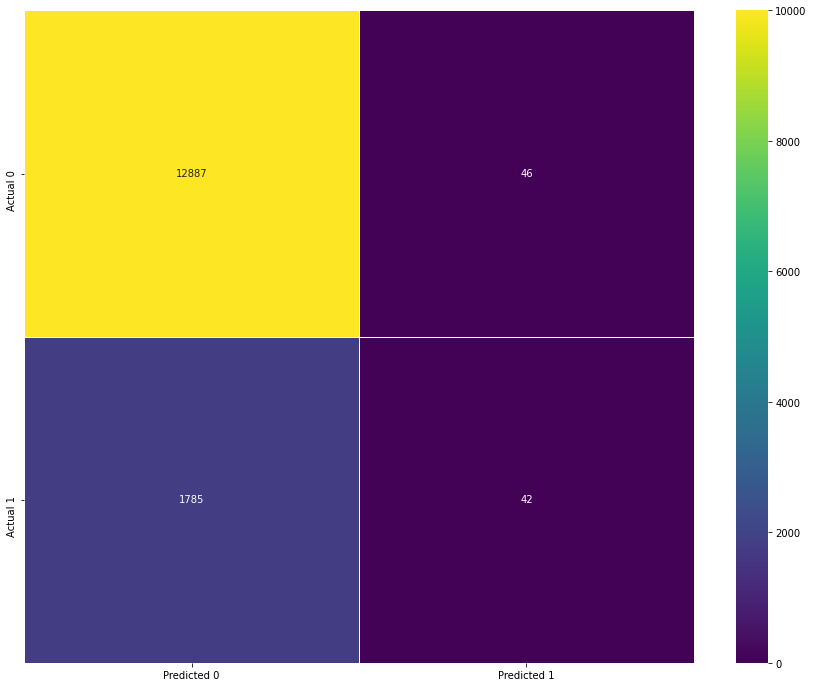

In [162]:
# Дополнительные метрики
print('Accuracy: \t\t', np.round(accuracy_score(y_test, predictions),4))
print('Precision: \t\t', np.round(precision_score(y_test, predictions),4))
print('Recall: \t\t', np.round(recall_score(y_test, predictions),4))
print('F1 score: \t\t', np.round(f1_score(y_test, predictions),4))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

### Промежуточный вывод

Не смотря на довольно высокий ROC AUC, модель не несет практической ценности, так как крайне редко предсказывает дефолт у клиентов (2.3%% от общего числа дефолтных клиентов). Применение данной модели несет в себе недооцентку риска дефолта и может привести к убыткам.

Данный дисбаланс в предсказаниях можно исправить, устранив дисбаланс выборки

## Oversampling

In [163]:
# Функция возвращает сбалансированную выборку для бинарной переменной
def bin_oversampling(df, col):
    vc = df[col].dropna().value_counts(ascending=False)
    value = vc.max()
    parts =[]
    parts.append(df[df[col]==vc.index[0]])
    for i in range(int(vc.max()/vc.min())):
        parts.append(df[df[col]==vc.index[1]])
    parts.append(df[df[col]==vc.index[1]].sample(n=vc.max()%vc.min(),random_state=RS))
    sample = pd.concat(parts)
    return sample

DEFAULT
0 (%%):	0.5
	 Среднее значение целевой:	0.0
1 (%%):	0.5
	 Среднее значение целевой:	1.0
Cтатистически значимые различия:	False


<Figure size 432x288 with 0 Axes>

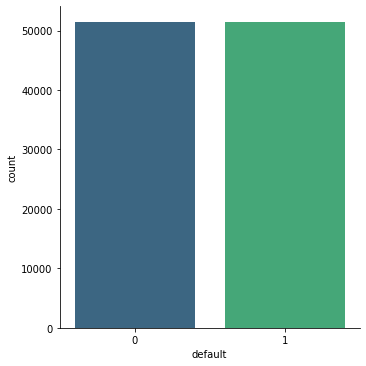

In [164]:
# Преобразование тренировочной выборки, визуализация
unbalanced = pd.DataFrame(X_train)
unbalanced['default'] = y_train
sample = bin_oversampling(unbalanced, 'default')
sum_up_cat(sample, 'default', 'default')

In [165]:
# Сбалансированная обучающая выборка
blncd_X_train = sample.copy().drop('default', axis = 1).values
blncd_y_train = sample['default'].copy().values

In [166]:
# Заново обучаем модель и делаем предсказания
model = LogisticRegression(random_state = RS)
model.fit(blncd_X_train, blncd_y_train)
predictions = model.predict(X_test)

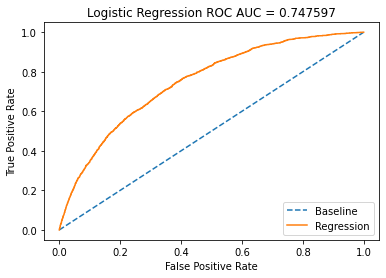

In [167]:
# Рассчет и визуализация ROC AUC
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Accuracy: 		 0.6663279132791328
Precision: 		 0.22525718339836823
Recall: 		 0.6951286261631089
F1 score: 		 0.3402545210984595
Confusion matrix:


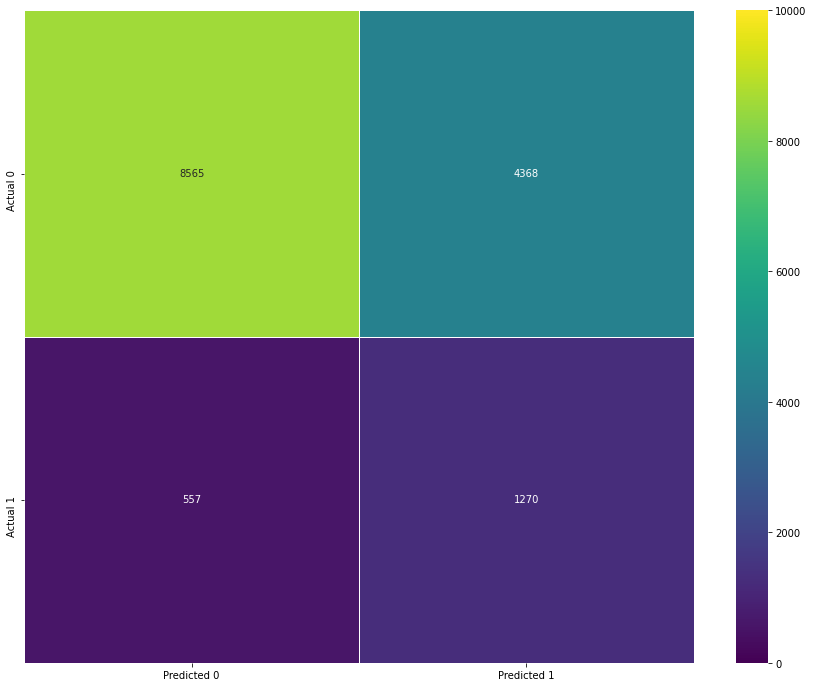

In [168]:
# Дополнительные метрики
print('Accuracy: \t\t', accuracy_score(y_test, predictions))
print('Precision: \t\t', precision_score(y_test, predictions))
print('Recall: \t\t', recall_score(y_test, predictions))
print('F1 score: \t\t', f1_score(y_test, predictions))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

### Промежуточный вывод

После изменения обучающей выборки, целевая метрика (ROC AUC) немного снизилась. Снизились так же accuracy и precision, но значительно вырос recall. Иными словами, модель усиленно ищет дефолтных клиентов:
- только 22.5% от клиентов, предсказанных как дефолтные, оказываются таковыми на самом деле.
- вместе с тем, дефолтных клиентов модель спобна предсказать в 69.5% случаев.

Данный консервативный подход больше подходит для внедрения модели.

(Ручная балансировка выборки дала чуть лучший recall по сравнению с гиперпараметром class_weight = 'balanced', встроенным в модель)

## Подбор гиперпараметров модели для максимизации ROC AUC

In [169]:
# Значения гиперпараметров для тестирования
C = [0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
warm_start = [True, False]


# Словарь гиперпараметров
hyperparameters = {'C': C, 'penalty': penalty, 
                   'solver': solver, 'warm_start':warm_start}

model = LogisticRegression(random_state = RS, max_iter=25)
model.fit(blncd_X_train, blncd_y_train)

# Создаем сетку поиска с использованием 3-кратной перекрестной проверки
gscv = GridSearchCV(model, hyperparameters, cv=3,
                   verbose=1, scoring='roc_auc')
best_model_gscv = gscv.fit(blncd_X_train, blncd_y_train)

print()
print('Лучший ROC AUC: \t', best_model_gscv.best_score_)
print()
for parameter in hyperparameters.keys():
    print('Лучший {}:\t'.format(parameter.upper()),
          best_model_gscv.best_estimator_.get_params()[parameter])

Fitting 3 folds for each of 80 candidates, totalling 240 fits

Лучший ROC AUC: 	 0.7364694249184084

Лучший C:	 10
Лучший PENALTY:	 l2
Лучший SOLVER:	 newton-cg
Лучший WARM_START:	 True


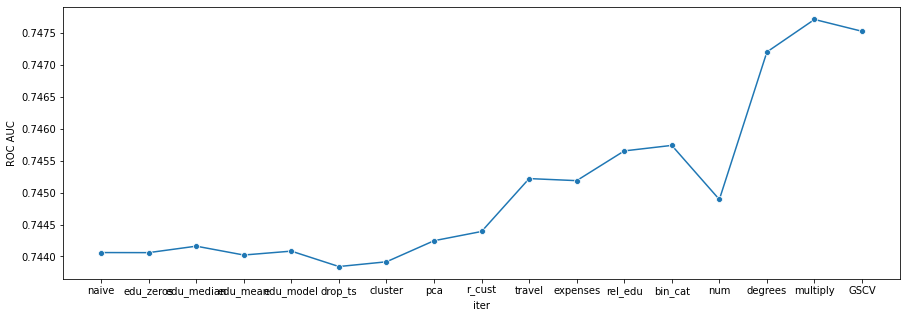

,naive,edu_zeros,edu_median,edu_mean,edu_model,drop_ts,cluster,pca,r_cust,travel,expenses,rel_edu,bin_cat,num,degrees,multiply,GSCV
ROC AUC,0.744060,0.744059,0.744161,0.744022,0.744083,0.743842,0.743916,0.744246,0.744391,0.745219,0.745187,0.745653,0.745739,0.744892,0.747203,0.747712,0.747527
Accuracy,0.874932,0.874932,0.875000,0.875000,0.874932,0.875068,0.874932,0.874593,0.875203,0.875136,0.875271,0.875203,0.875068,0.875000,0.875474,0.875949,0.875881
Precision,0.405941,0.405941,0.411765,0.410000,0.407767,0.410526,0.402062,0.384615,0.431193,0.432203,0.438596,0.433628,0.426087,0.421053,0.452174,0.477273,0.471910
Recall,0.022441,0.022441,0.022989,0.022441,0.022989,0.021346,0.021346,0.021894,0.025725,0.027915,0.027367,0.026820,0.026820,0.026273,0.028462,0.022989,0.022989
F1 score,0.042531,0.042531,0.043546,0.042553,0.043523,0.040583,0.040541,0.041429,0.048554,0.052442,0.051520,0.050515,0.050463,0.049459,0.053553,0.043864,0.043841


In [170]:
# Визуализация
results['GSCV'] = metics(train, 'default', model=LogisticRegression(C=10, max_iter=25, 
                                                                    penalty='l2', random_state=RS,
                                                                    solver='newton-cg', warm_start=True))

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=results.loc['ROC AUC'].index, y=results.loc['ROC AUC'].values, 
                  marker='o')
ax.set(ylabel='ROC AUC', xlabel='iter')
plt.show()

results

После подбора параметров модели, ROC AUC немного снизился. Вместе с тем, модель с данными параметрами должна быть более устойчивой.

In [171]:
best_model = best_model_gscv.best_estimator_

In [172]:
# Измерение точности модели, выбранной при помощи GridSearchCV, в зависимости от кол-ва итераций
start_time = time.time()
model_test = []
for n_iter in range(1, 51, 1):
    model = LogisticRegression(C=10, max_iter=n_iter, penalty='l2', random_state=RS,
                               solver='newton-cg', warm_start=True)
    model.fit(blncd_X_train, blncd_y_train)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    model_test.append(roc_auc_score(y_test, probs))
    print(('Processing: {} %'.format(n_iter*2)), end="\r")
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	478.72872376441956 sec.


Лучший результат модели (ROC_AUC = 0.7474846892055477) при параметре = Int64Index([7], dtype='int64')



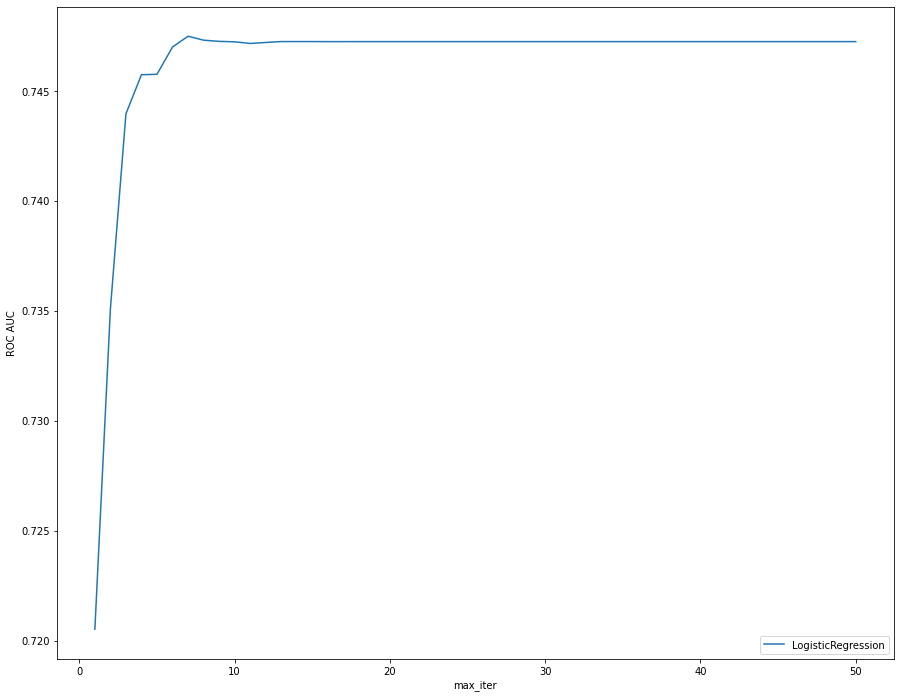

In [173]:
# Визуализация результатов
r = pd.Series(model_test, index = [x for x in range(1, 51, 1)])
print('Лучший результат модели (ROC_AUC = {}) при параметре = {}'.format(r.max(), r[r == r.max()].index))
print()

plt.figure(figsize=(15, 12))
ax = sns.lineplot(x=range(1, 51, 1), y=r, label='LogisticRegression')
ax.set(ylabel='ROC AUC', xlabel='max_iter')
plt.legend(loc='lower right')
plt.show()

К 25ти итерациям модель находится на плато. Нет необходимости менять параметр.

# Submission

## Data preprocessing

In [174]:
# Функция возвращает данные после предобработки
def preprocessing(df):
    
    # Удаление 'client_id'
    df.drop('client_id', axis = 1, inplace = True)
    
    # Перевод 'app_date' в формат datetime
    df.app_date = pd.to_datetime(df.app_date, infer_datetime_format=True)
    
    # Кодировка бинарных признаков
    for column in obj_cols(df, bin_cols[:-1]):
        df[column] = label_encoder.fit_transform(df[column])
    
    # Кодировка 'education'
    mapping_dict = {'SCH': 1, 'UGR': 2, 'GRD':3, 'PGR':4, 'ACD':5}
    df['education'] = df.education.map(mapping_dict)
    
    # Нормализация признаков
    for col in ['decline_app_cnt', 'bki_request_cnt']:
        df[col] = df[col].apply(lambda x: x+1)
    for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
        df[col] = stats.boxcox(df[col])[0]
    
    # Изменение размерности 'region_rating'
    df['region_rating'] = df['region_rating']/100
    
    # Перевод 'decline_app_cnt' в категориальный признак
    df['decline_app_cnt'] = df.decline_app_cnt.apply(lambda x: 1 if x>0 else 0)
    
    # Создание 'app_month' и 'timestamp', удаление 'app_date'
    df['app_month'] = df.app_date.dt.month
    df['timestamp'] = df.app_date.values.astype(np.int64) // 10 ** 9
    df.drop('app_date', axis = 1, inplace = True)
    
    # Заполнение пропусков 'education'
    df['education'].fillna(train['education'].median(), inplace=True)
    
    # Итог PCA
    df['bki_ovrl'] = (df.score_bki - df.score_bki.min())*df.bki_request_cnt.values
    df.drop('bki_request_cnt', axis = 1, inplace = True)
    
    # Переменные на основе логики
    df['reliable_cust'] = df.first_time - df.sna
    df['travel_time'] = df.home_address - df.work_address
    df['travel_time'] = df.travel_time.apply(lambda x: -x if x<0 else x)
    df['relative_edu'] = df.education/df.age
    df['relative_edu'] = stats.boxcox(df['relative_edu'])[0]
    
    # Агрегированные переменные
    df['bin_cat_rating'] = df[['car', 'car_type', 'good_work', 'foreign_passport',
                                 'education', 'first_time', 'app_month']].sum(axis=1) - df[['sex', 'decline_app_cnt', 
                                                                                               'work_address', 'sna']].sum(axis=1)
    df['bin_cat_rating'] = df['bin_cat_rating'] + 7
    
    # Полиноминалы
    df_poly = df.copy()
    
    for col in num_cols_help:
        for degree in [2,3]:
            name = '{}^{}'.format(col, degree)
            df_poly[name] = df_poly[col]**degree
        name  = '1/{}'.format(col)
        df_poly[name] = 1/(df_poly[col]+1)
    
    for feature in degree_features:
        df[feature] = df_poly[feature]
    
    for pair in list(combinations(num_cols_help, 2)):
        name = '{}*{}'.format(pair[0],pair[1])
        df_poly[name] = df_poly[pair[0]]*df_poly[pair[1]]
    
    for feature in multiply_features:
        df[feature] = df_poly[feature]
    
    return df

In [175]:
# Повторная загрузка данных
test = pd.read_csv(DATA_DIR+'test.csv')

In [176]:
client_id = test.client_id

In [177]:
# Создание 'default' в тестовых данных
test['default'] = 100

In [178]:
# Предобработка и результат
valid= preprocessing(test)
valid.sample(5)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,region_rating,home_address,...,age^2,1/age,income^2,income^3,region_rating^2,region_rating^3,bki_ovrl^2,age*income,age*region_rating,score_bki*bin_cat_rating
35229,2.0,1,3.262578,0,0,1,0,-2.275019,0.6,2,...,10.644414,0.234600,33.213585,191.413974,0.36,0.216,2.710728,18.802637,1.957547,-18.200154
9060,1.0,1,2.781051,1,0,1,0,-2.319712,0.5,2,...,7.734244,0.264477,33.807116,196.567713,0.25,0.125,0.690718,16.170111,1.390525,-20.877404
139,1.0,0,3.161392,0,0,0,0,-2.108725,0.4,1,...,9.994402,0.240304,31.931318,180.436863,0.16,0.064,0.942593,17.864334,1.264557,-16.869800
4117,1.0,0,3.390190,0,0,0,1,-1.652460,0.4,1,...,11.493391,0.227781,33.038198,189.899809,0.16,0.064,3.864519,19.486429,1.356076,-19.829524
30106,1.0,0,3.350345,1,0,0,0,-1.889233,0.4,2,...,11.224811,0.229867,30.108785,165.211335,0.16,0.064,0.000000,18.383836,1.340138,-18.892326


In [179]:
# Проверка, что данные содержат одинаковое кол-во признаков
print(len(train.columns)-len(test.columns))

0


## Предобработка для моделирования

In [180]:
# Обработка признаков для модели
X_valid_cat = main_OHE.transform(valid[cat_cols].values)
X_valid_num = main_SS.transform(valid[num_cols].values)
X_valid = np.hstack([X_valid_num, valid[bin_cols].values, X_valid_cat])

## Применение модели

In [181]:
predictions = best_model.predict(X_valid)

probs = best_model.predict_proba(X_valid)
probs = probs[:, 1]

In [182]:
result = pd.DataFrame({'client_id': client_id, 'default': probs})

In [183]:
result

,client_id,default
0,74835,0.168890
1,17527,0.776723
2,75683,0.359855
3,26883,0.380889
4,28862,0.131774
...,...,...
36344,83775,0.804827
36345,106254,0.090481
36346,81852,0.758249
36347,1971,0.646509


In [184]:
result.to_csv('submission.csv', index = False)